In [1]:
# imports
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import imutils
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Input, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [2]:
# functions
IMG_SIZE = (240, 240)

def plot_samples(X, y, n=30):
  """
  Creates a gridplot for desired number of images (n) from the specified set
  """
  for index in [0,1]:
    imgs = X[np.argwhere(y == index)][:n]
    j = 10
    i = int(n/j)

    plt.figure(figsize=(15,6))
    c = 1
    for img in imgs:
      plt.subplot(i,j,c)
      plt.imshow(img[0])

      plt.xticks([])
      plt.yticks([])
      c += 1
    plt.suptitle('Tumor: {}'.format(index))
    plt.show()

def crop_brain_contour(image):
  # Convert the image to grayscale, and blur it slightly
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)

  # Threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # Find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)


  # Find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  # crop new image out of the original image using the four extreme points (left, right, top, bottom)
  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  return new_image

def perform_preprocesing(img, img_size, preproces=True):
  # crop the contour
  if preproces:
    img = crop_brain_contour(img)
  # resize image
  img = cv2.resize(img, img_size, interpolation=cv2.INTER_CUBIC)
  # normalize
  return img / 255

def load_data(img_size=IMG_SIZE, preproces=True):

  # download the dataset from kaggle
  path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
  path = os.path.join(path, "brain_tumor_dataset")

  X = []
  y = []

  images2remove = [
    "Y147.JPG", # different perspective
    "Y248.JPG", # not a brain
    "19 no.jpg", # different perspective
    "Y51.jpg", # different perspective
    "Y104.jpg", # different perspective
    "Y147.jpg", # different perspective
    "N15.jpg", # looks like tumor, but in no folder
    "N16.jpg", # looks like tumor, but in no folder
    "N17.jpg", # looks like tumor, but in no folder
    "N11.jpg", # looks like tumor, but in no folder
    "Y185.jpg", # looks like no tumor, but in yes folder
    "Y187.jpg", # looks like no tumor, but in yes folder
    "Y188.jpg", # looks like no tumor, but in yes folder
  ]
  for dir in os.listdir(path):
    print('From', dir)
    for filename in os.listdir(path + '/' + dir):
      # remove is needed
      if filename in images2remove:
        print('Removing', filename)
        continue
      full_path = os.path.join(path, dir, filename)
      image = cv2.imread(full_path)
      image = perform_preprocesing(image, img_size)
      X.append(image)
      y.append([1]) if dir == 'yes' else y.append([0])
  X, y = np.array(X), np.array(y)
  X, y = shuffle(X, y)
  return X, y

def plot_metrics(model):
  history = model.history.history
  train_loss = history['loss']
  val_loss = history['val_loss']
  train_acc = history['accuracy']
  val_acc = history['val_accuracy']

  # Loss
  plt.figure()
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.legend()
  plt.show()

  # Accuracy
  plt.figure()
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

def plot_confusion_matrix(y, pred):
  confusion_mtx = confusion_matrix(y, pred)
  cm = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mtx, display_labels = [0, 1])
  cm.plot()
  plt.show()

def test_model(model, X_test, y_test, verbose):
  predictions = model.predict(X_test, verbose=1 if verbose else 0)
  predictions = [1 if x>0.5 else 0 for x in predictions]

  acc = accuracy_score(y_test, predictions)
  print('accuracy = %.2f' % acc)
  f1 = f1_score(y_test, predictions)
  print('f1 score = %.2f' % f1)

  plot_confusion_matrix(y_test, predictions)
  return acc, f1

def perform_training_on_model(model, X, y, epochs=5, batch_size=32, callbacks=[], verbose=False):
  if verbose:
    print(f'Data shapes: {X.shape}, {y.shape}')

    # Step 2. plot the data
    plot_samples(X, y)

    # Get model info
    print('Model info:')
    model.summary()

  # Step 3. create test and train data
  print('Fitting the model...')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks, verbose=1 if verbose else 0)

  if verbose:
    # Step 4. plot the learning data
    plot_metrics(model)

  # Step 5. test model on test data
  acc, f1 = test_model(model, X_test, y_test, verbose)

  return acc, f1

In [3]:
# various models
def get_model_v1():
  model = Sequential([
    Input((IMG_SIZE[0],IMG_SIZE[1] ,3)),

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Flatten
    Flatten(),

    Dense(1,activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

def get_model_v1_custom(out_dimension=128, kernel_window_size=3, pooling_window_size=2):
  model = Sequential([
    Input((IMG_SIZE[0],IMG_SIZE[1] ,3)),

    # First convolutional block
    Conv2D(out_dimension, (kernel_window_size, kernel_window_size), activation='relu'),
    MaxPooling2D(pool_size=(pooling_window_size, pooling_window_size)),
    Dropout(0.3),

    # Flatten
    Flatten(),

    Dense(1,activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [6]:
m1 = get_model_v1()
m1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 240, 240, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 240, 240, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 240, 240, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 460800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │         460,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,073 (1.80 MB)

 Trainable params: 471,009 (1.80 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
# Load data
X, y = load_data(preproces=True)

100%|██████████| 15.1M/15.1M [00:00<00:00, 116MB/s] 

Extracting files...


From yes
Removing Y185.jpg
Removing Y147.JPG
Removing Y248.JPG
Removing Y187.jpg
Removing Y104.jpg
Removing Y188.jpg
Removing Y51.jpg
From no
Removing N16.jpg
Removing 19 no.jpg
Removing N15.jpg
Removing N17.jpg
Removing N11.jpg


Fitting the model...
accuracy = 0.63
f1 score = 0.71


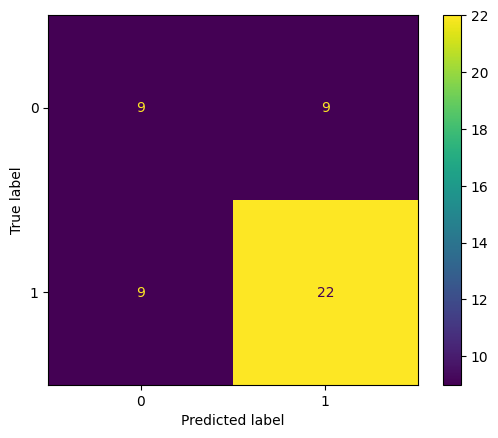

In [ ]:
# get so far the best model
m1 = get_model_v1()
acc, f1 = perform_training_on_model(m1, X, y, epochs=8, verbose=False)

best = {
    acc: (m1, f1)
}

Params: output_size:16 | kernel_size:3 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.71
f1 score = 0.79


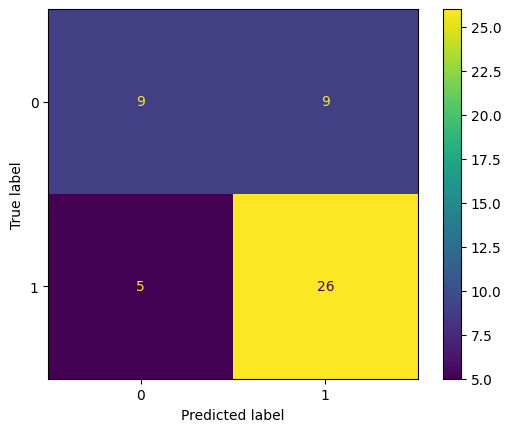

Params: output_size:16 | kernel_size:3 | pooling_size:2 | epochs:8
Fitting the model...


accuracy = 0.73
f1 score = 0.80


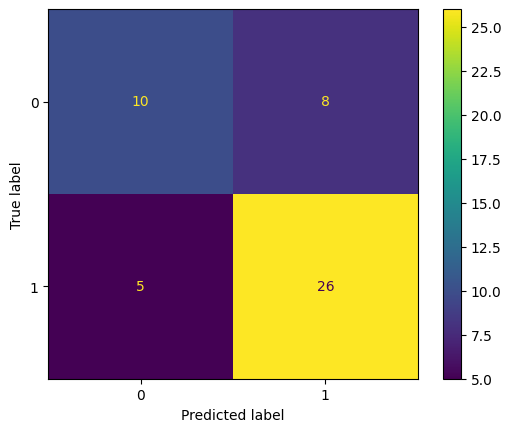

Params: output_size:16 | kernel_size:3 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.83


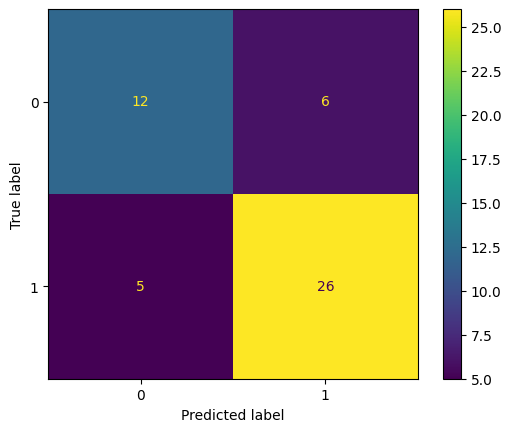

Params: output_size:16 | kernel_size:3 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


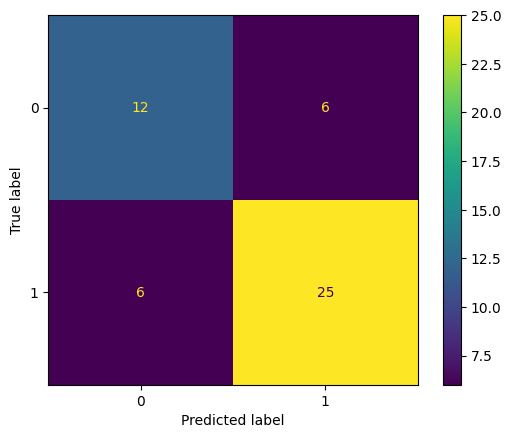

Params: output_size:16 | kernel_size:3 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.69
f1 score = 0.75


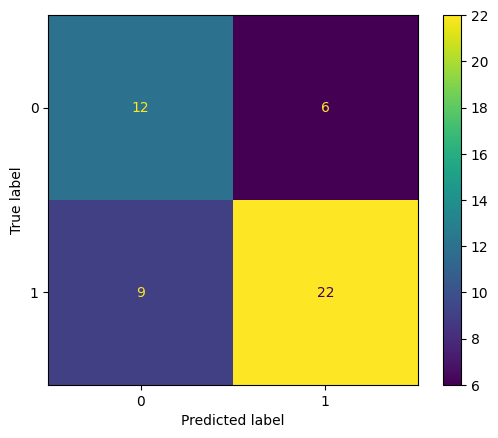

Params: output_size:16 | kernel_size:3 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.71
f1 score = 0.76


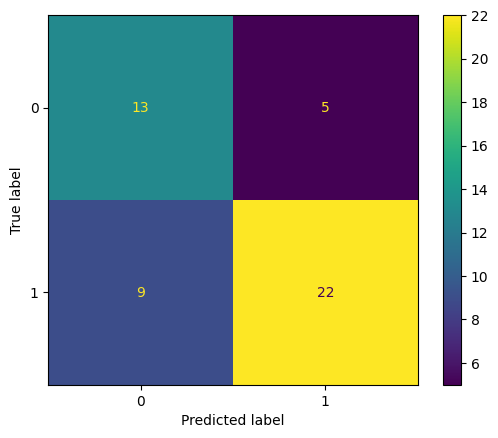

Params: output_size:16 | kernel_size:3 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.69
f1 score = 0.75


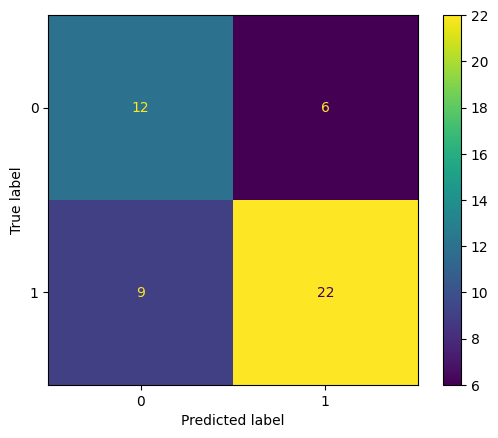

Params: output_size:16 | kernel_size:3 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


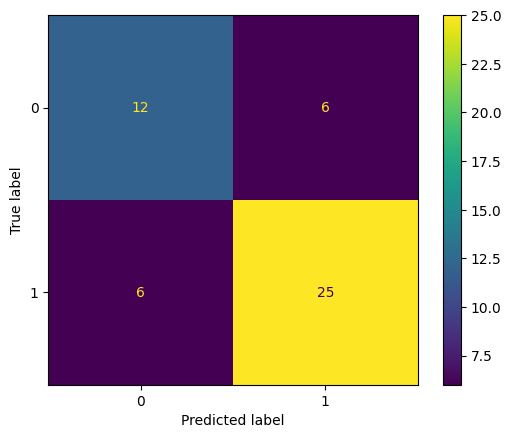

Params: output_size:16 | kernel_size:3 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.61
f1 score = 0.71


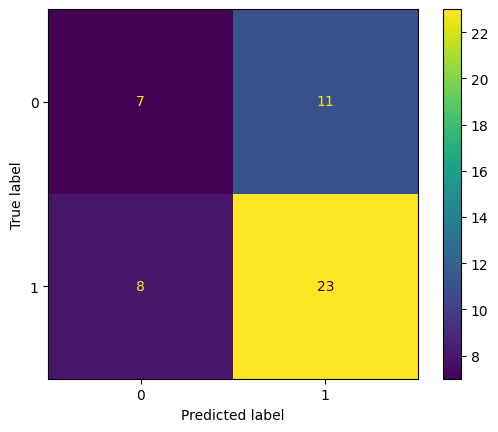

Params: output_size:16 | kernel_size:3 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.67
f1 score = 0.72


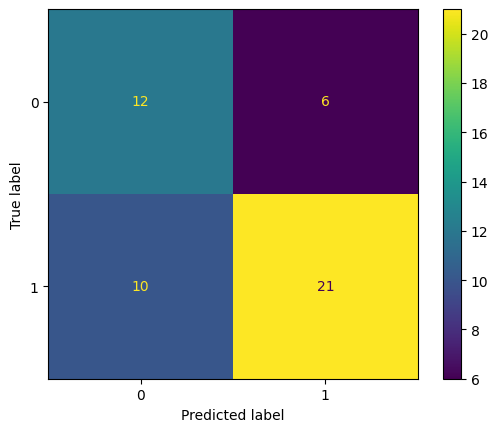

Params: output_size:16 | kernel_size:3 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.71
f1 score = 0.78


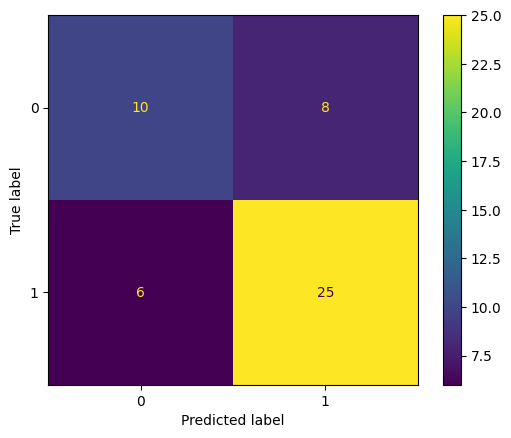

Params: output_size:16 | kernel_size:3 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.73
f1 score = 0.77


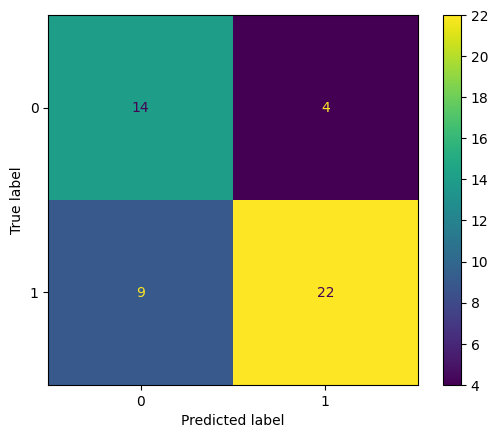

Params: output_size:16 | kernel_size:4 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.71
f1 score = 0.74


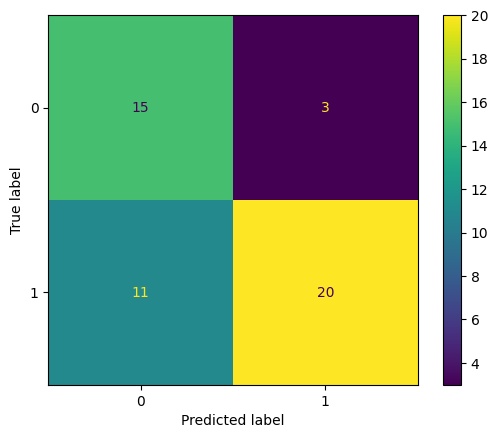

Params: output_size:16 | kernel_size:4 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.73
f1 score = 0.79


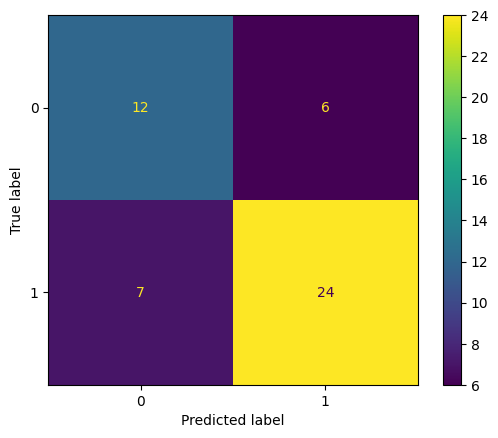

Params: output_size:16 | kernel_size:4 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.82


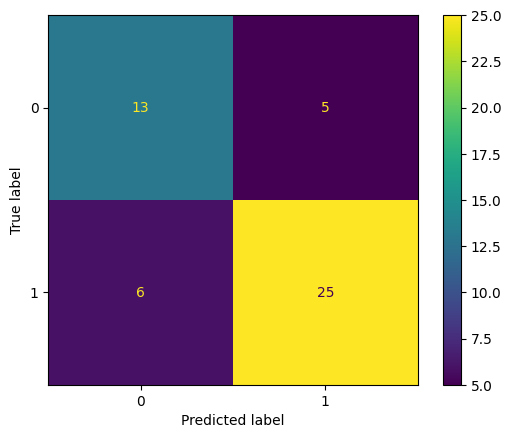

Params: output_size:16 | kernel_size:4 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


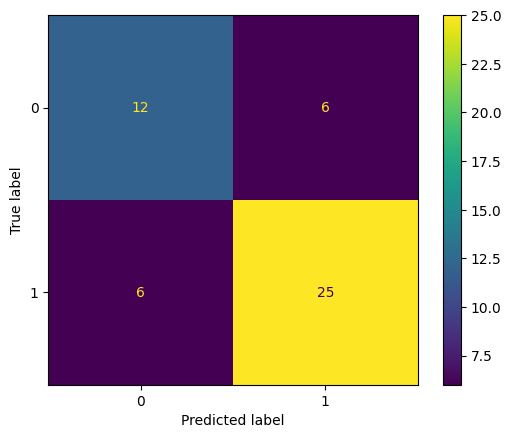

Params: output_size:16 | kernel_size:4 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.63
f1 score = 0.72


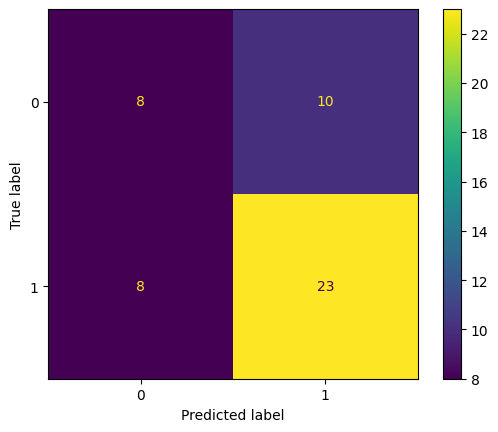

Params: output_size:16 | kernel_size:4 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.71
f1 score = 0.74


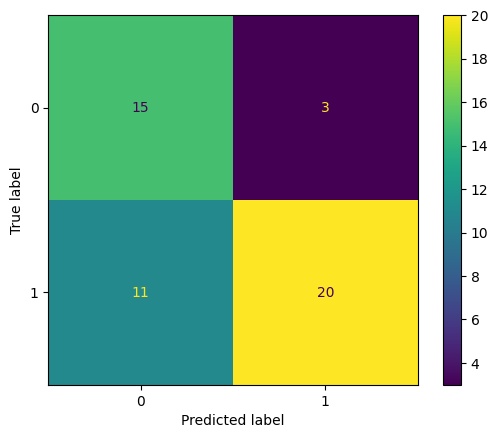

Params: output_size:16 | kernel_size:4 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.76
f1 score = 0.81


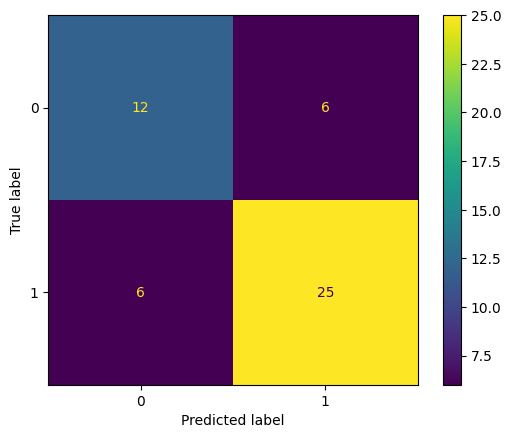

Params: output_size:16 | kernel_size:4 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


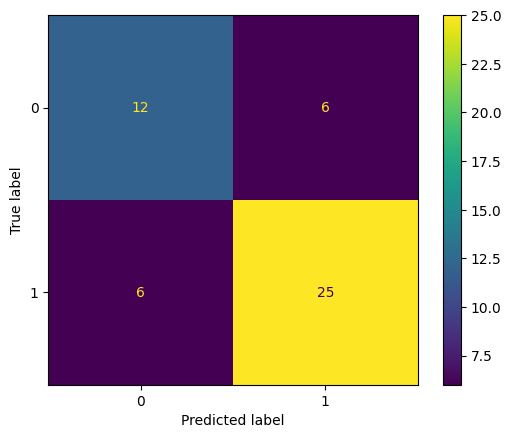

Params: output_size:16 | kernel_size:4 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.71
f1 score = 0.78


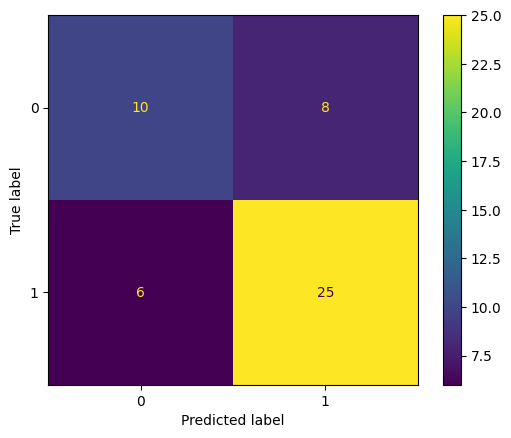

Params: output_size:16 | kernel_size:4 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.73
f1 score = 0.80


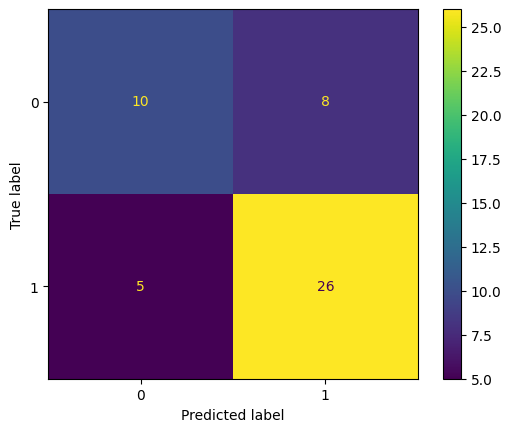

Params: output_size:16 | kernel_size:4 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.78


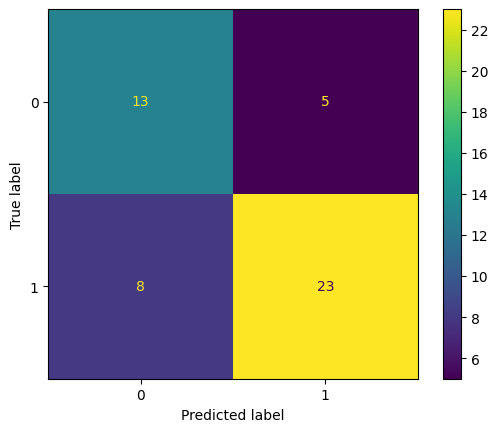

Params: output_size:16 | kernel_size:4 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


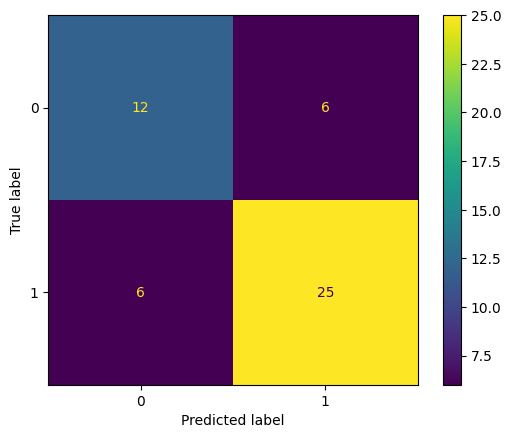

Params: output_size:16 | kernel_size:5 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.67
f1 score = 0.75


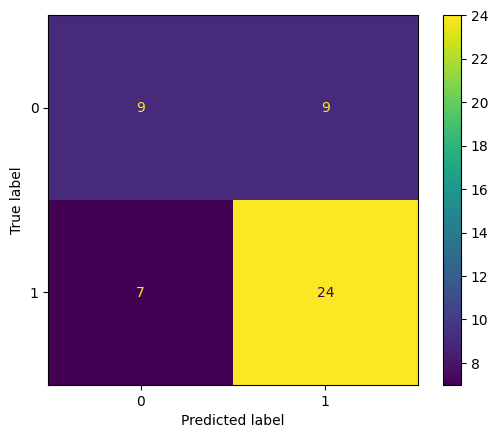

Params: output_size:16 | kernel_size:5 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.73
f1 score = 0.77


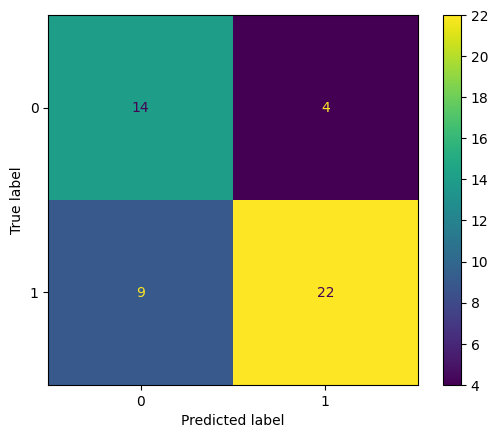

Params: output_size:16 | kernel_size:5 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.82


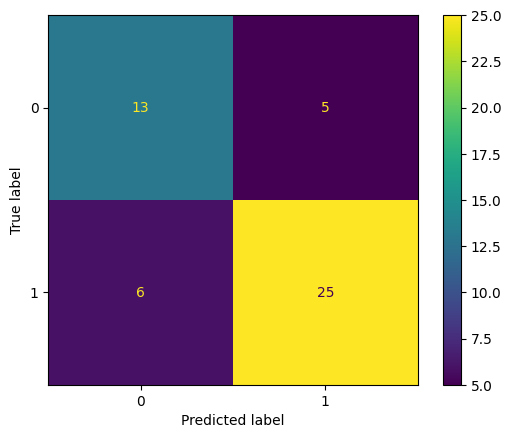

Params: output_size:16 | kernel_size:5 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.82


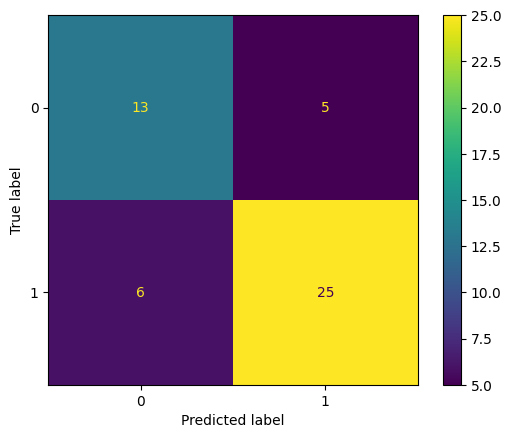

Params: output_size:16 | kernel_size:5 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.55
f1 score = 0.62


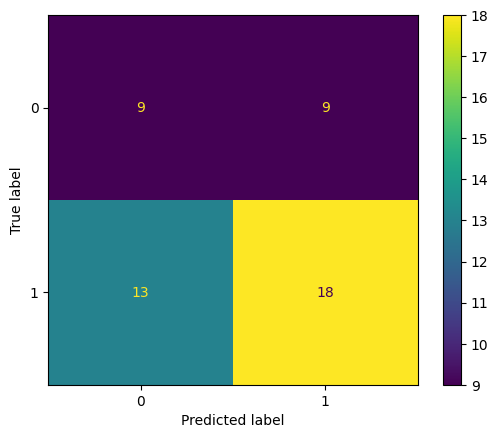

Params: output_size:16 | kernel_size:5 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.81


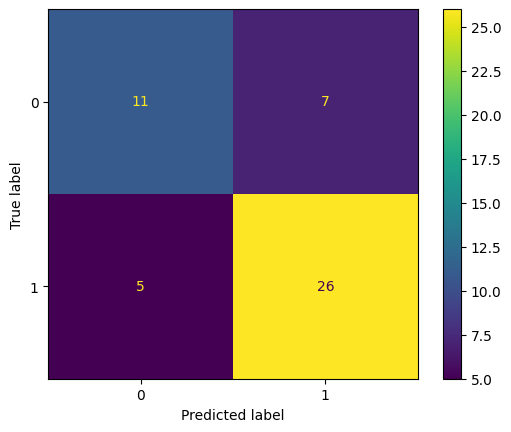

Params: output_size:16 | kernel_size:5 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.69
f1 score = 0.75


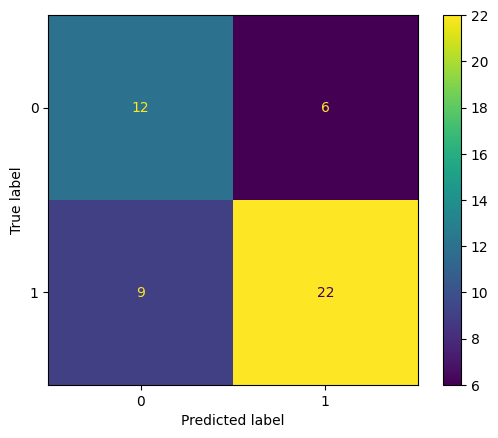

Params: output_size:16 | kernel_size:5 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.73
f1 score = 0.79


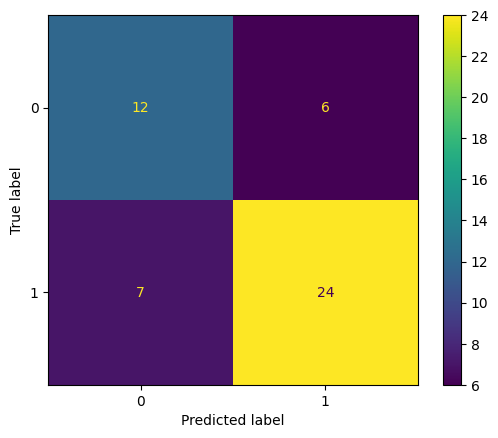

Params: output_size:16 | kernel_size:5 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.63
f1 score = 0.74


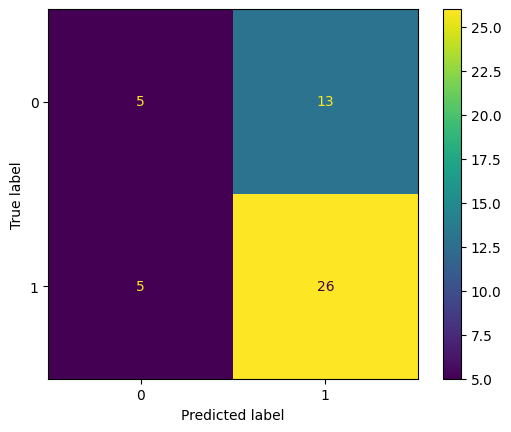

Params: output_size:16 | kernel_size:5 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.81


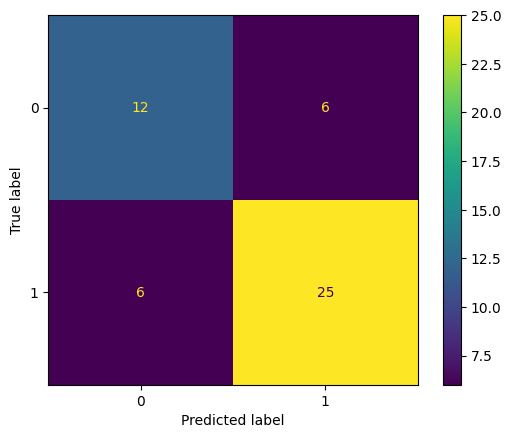

Params: output_size:16 | kernel_size:5 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.76
f1 score = 0.80


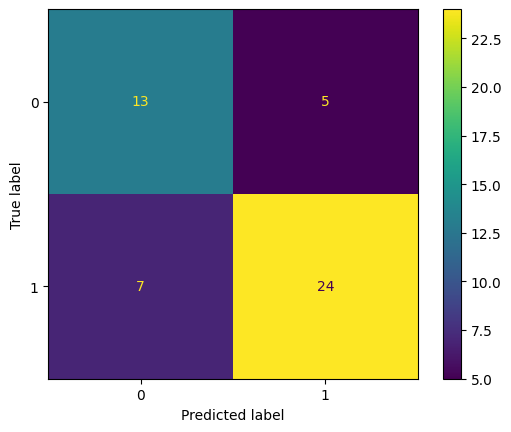

Params: output_size:16 | kernel_size:5 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.83


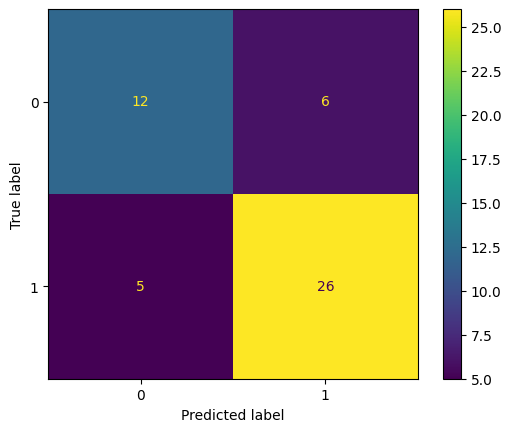

Params: output_size:32 | kernel_size:3 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.76
f1 score = 0.80


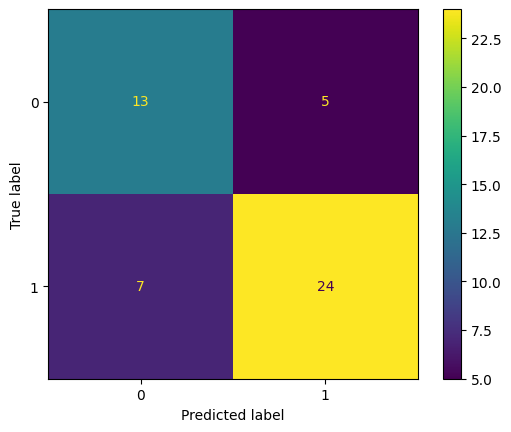

Params: output_size:32 | kernel_size:3 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.78
f1 score = 0.83


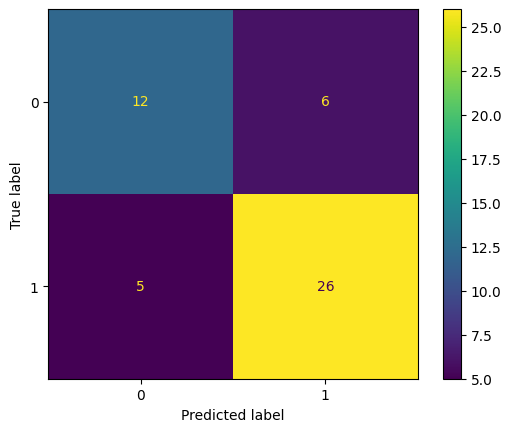

Params: output_size:32 | kernel_size:3 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.83


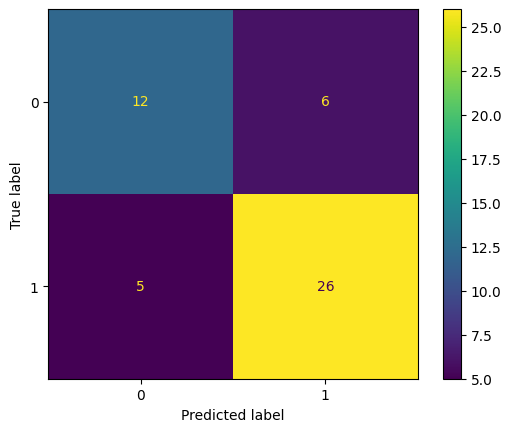

Params: output_size:32 | kernel_size:3 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


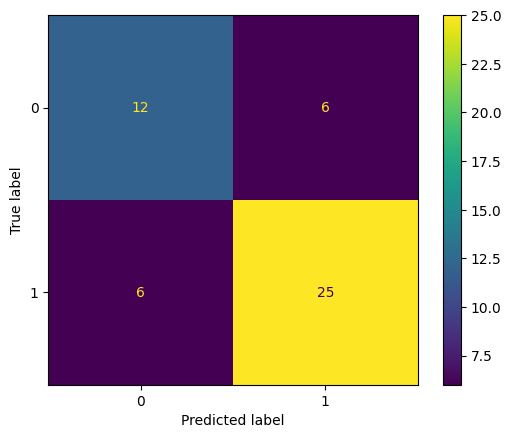

Params: output_size:32 | kernel_size:3 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.65
f1 score = 0.70


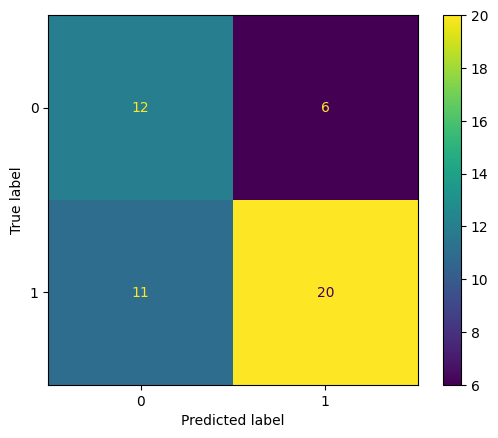

Params: output_size:32 | kernel_size:3 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.71
f1 score = 0.79


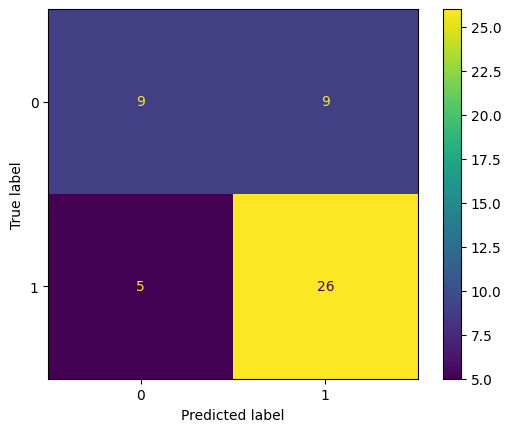

Params: output_size:32 | kernel_size:3 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.69
f1 score = 0.74


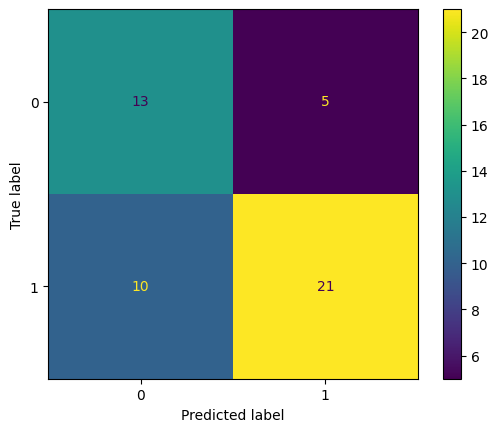

Params: output_size:32 | kernel_size:3 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.80


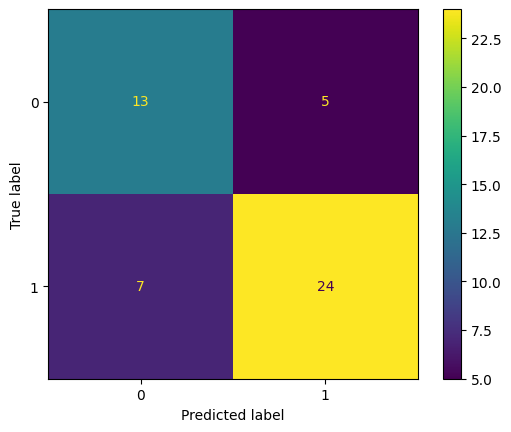

Params: output_size:32 | kernel_size:3 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.63
f1 score = 0.73


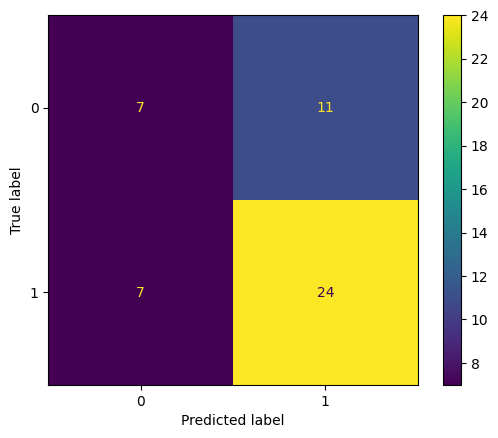

Params: output_size:32 | kernel_size:3 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.73
f1 score = 0.79


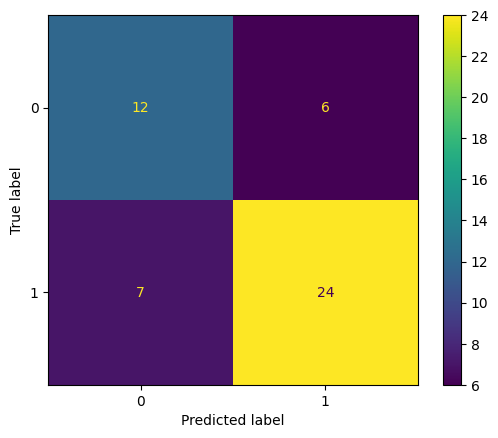

Params: output_size:32 | kernel_size:3 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.77


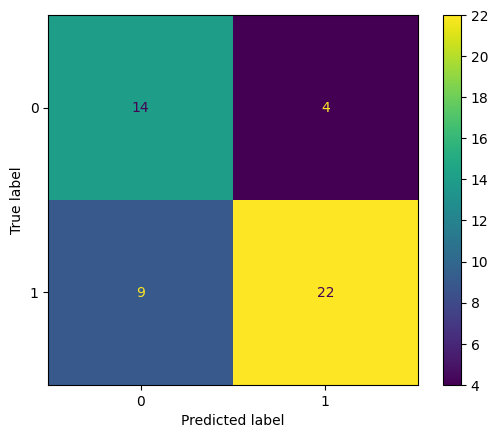

Params: output_size:32 | kernel_size:3 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


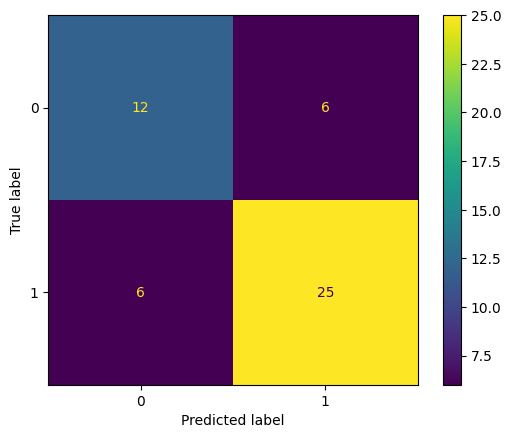

Params: output_size:32 | kernel_size:4 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.69
f1 score = 0.78


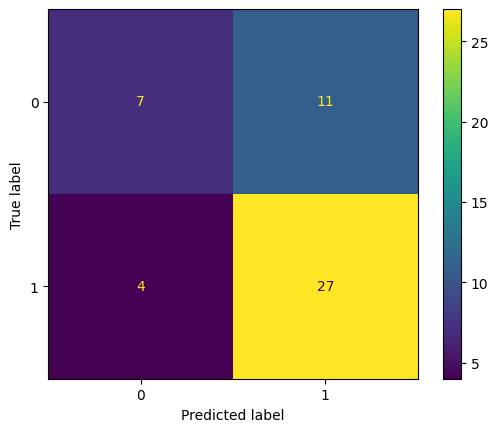

Params: output_size:32 | kernel_size:4 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.78
f1 score = 0.81


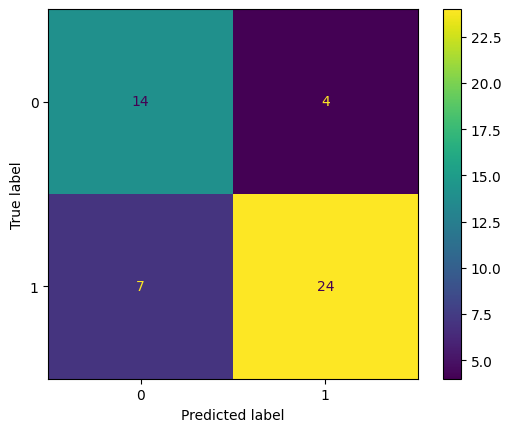

Params: output_size:32 | kernel_size:4 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.82


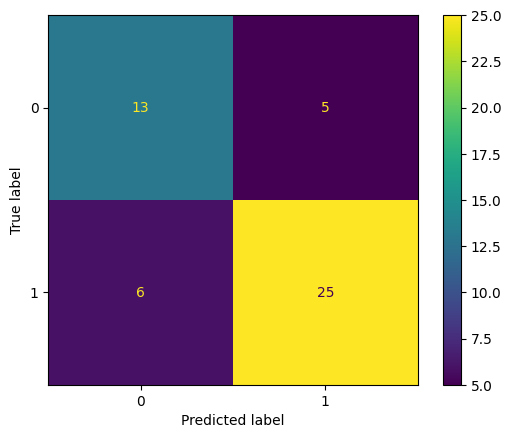

Params: output_size:32 | kernel_size:4 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.84
f1 score = 0.87


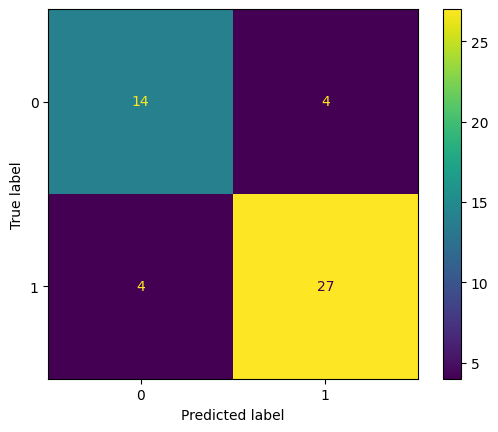

Params: output_size:32 | kernel_size:4 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.71
f1 score = 0.77


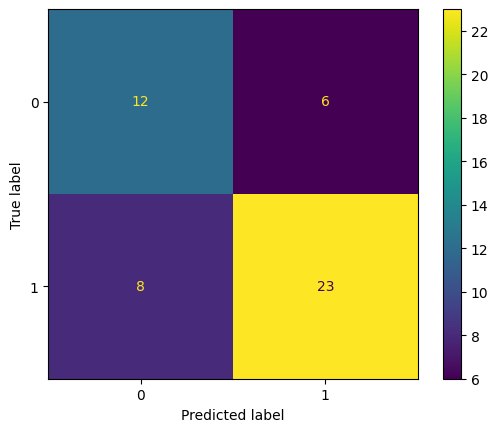

Params: output_size:32 | kernel_size:4 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.78
f1 score = 0.83


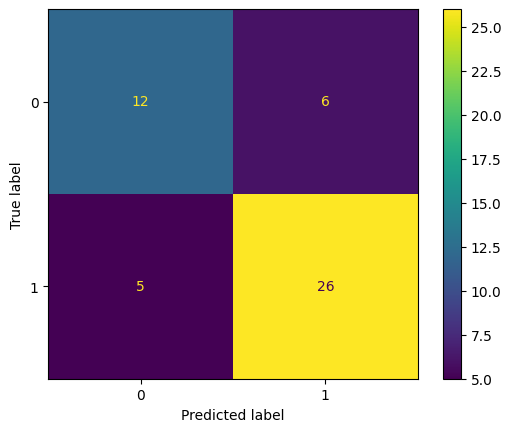

Params: output_size:32 | kernel_size:4 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.83


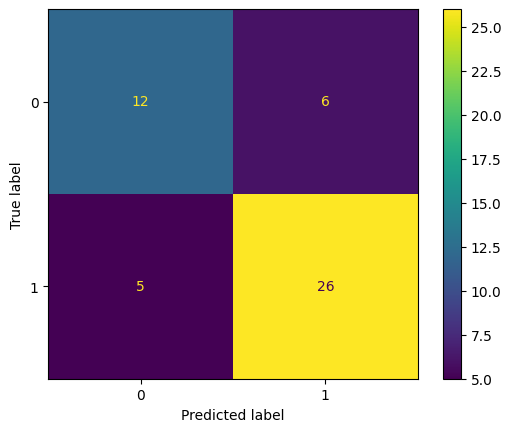

Params: output_size:32 | kernel_size:4 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


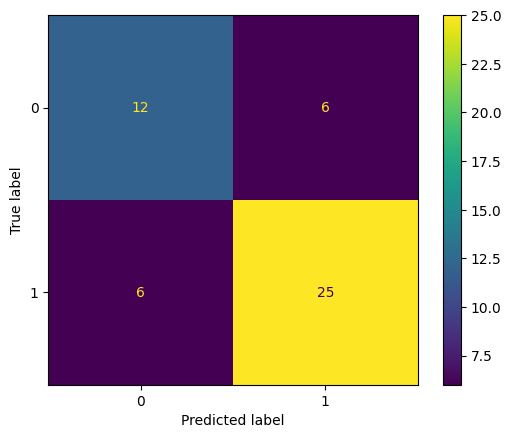

Params: output_size:32 | kernel_size:4 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.69
f1 score = 0.75


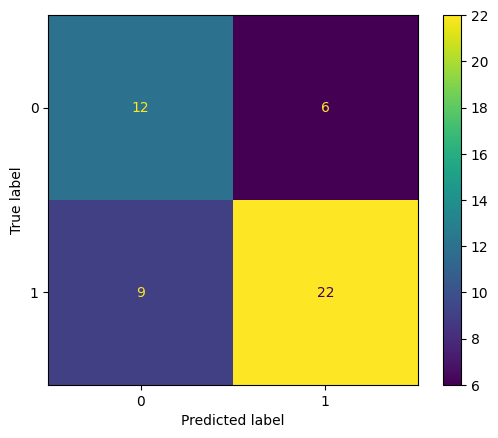

Params: output_size:32 | kernel_size:4 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.81


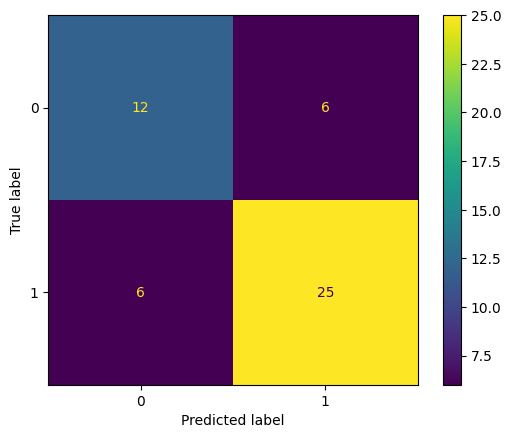

Params: output_size:32 | kernel_size:4 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.83


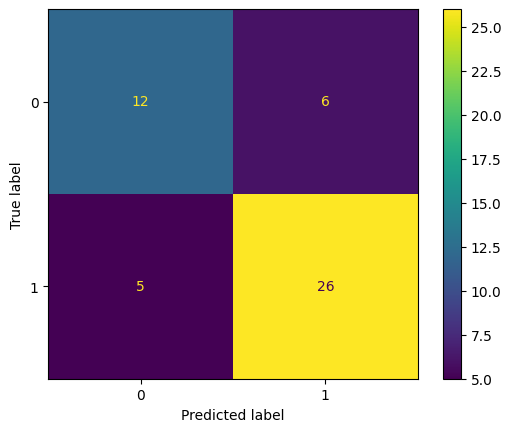

Params: output_size:32 | kernel_size:4 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


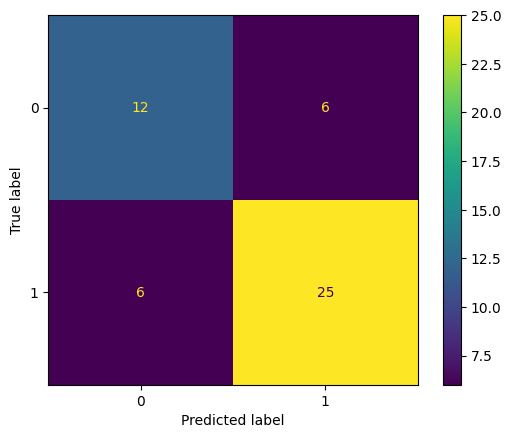

Params: output_size:32 | kernel_size:5 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.63
f1 score = 0.62


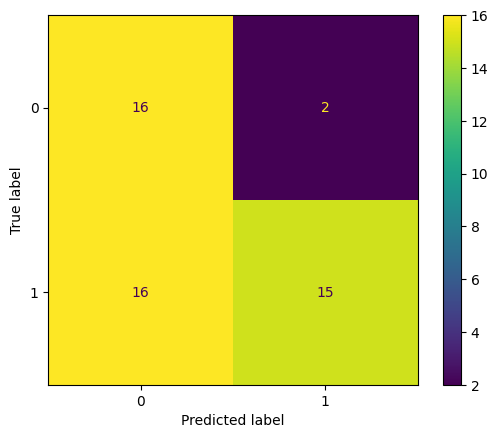

Params: output_size:32 | kernel_size:5 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.78
f1 score = 0.81


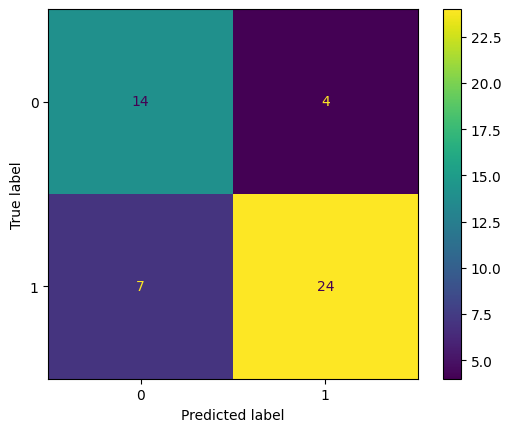

Params: output_size:32 | kernel_size:5 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.80
f1 score = 0.83


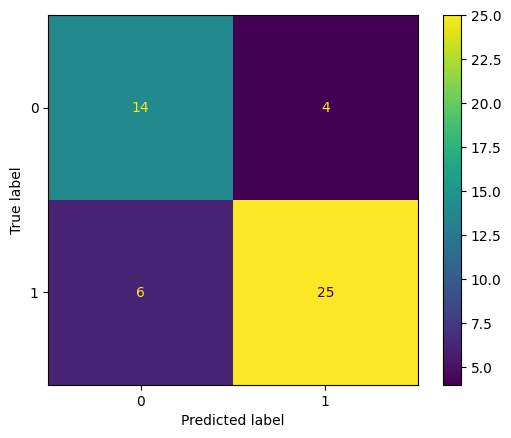

Params: output_size:32 | kernel_size:5 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.82


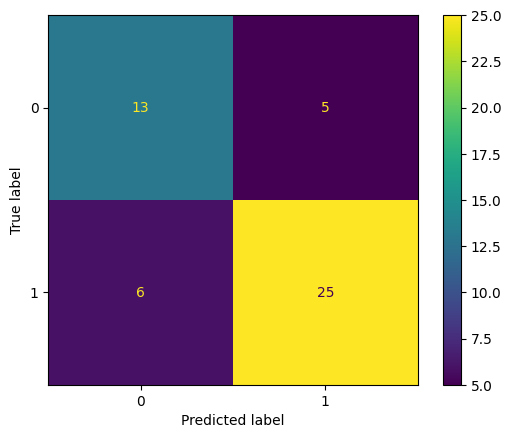

Params: output_size:32 | kernel_size:5 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.65
f1 score = 0.77


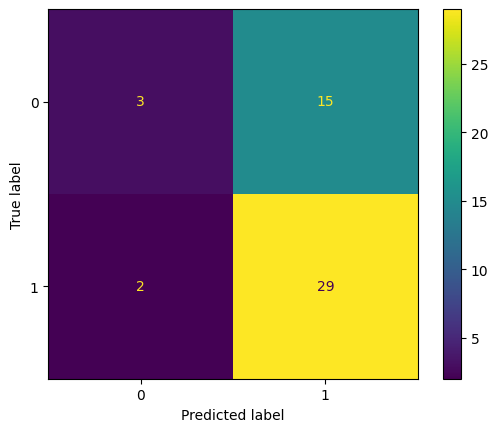

Params: output_size:32 | kernel_size:5 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.71
f1 score = 0.79


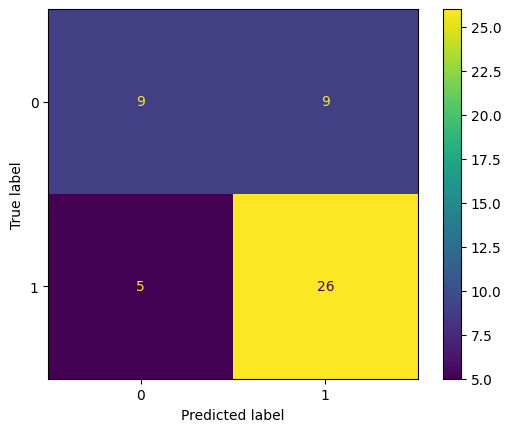

Params: output_size:32 | kernel_size:5 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.76
f1 score = 0.80


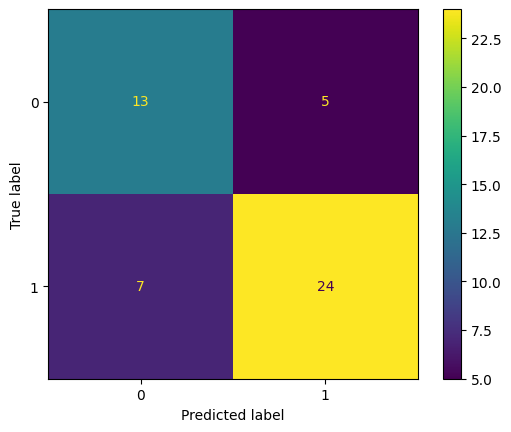

Params: output_size:32 | kernel_size:5 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.82


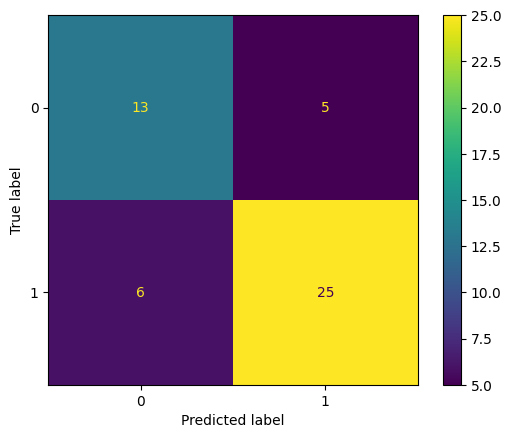

Params: output_size:32 | kernel_size:5 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.59
f1 score = 0.67


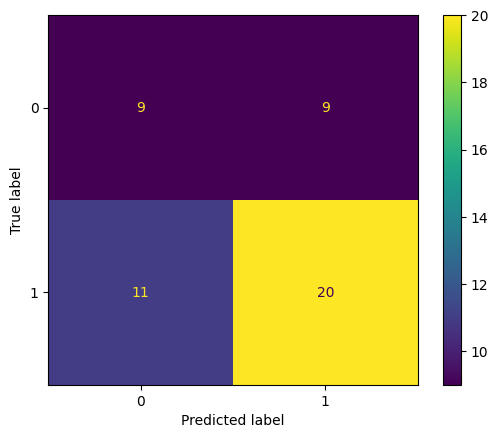

Params: output_size:32 | kernel_size:5 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.81


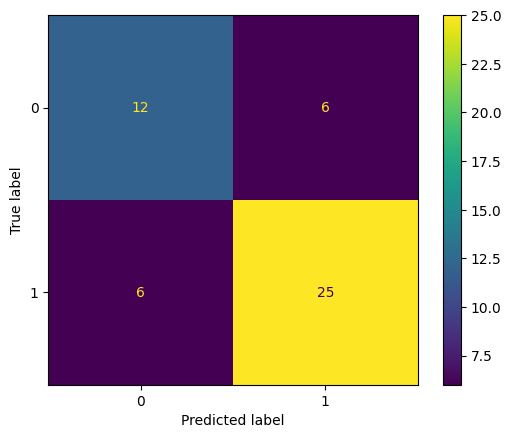

Params: output_size:32 | kernel_size:5 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.78


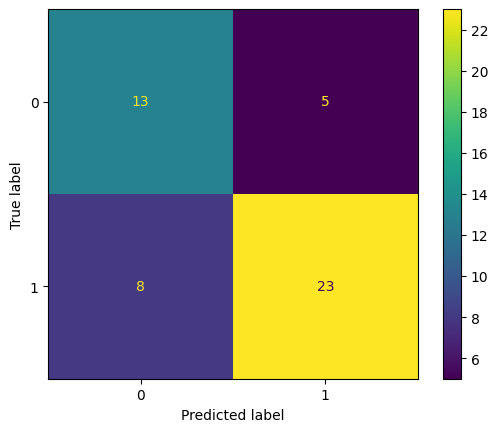

Params: output_size:32 | kernel_size:5 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.81


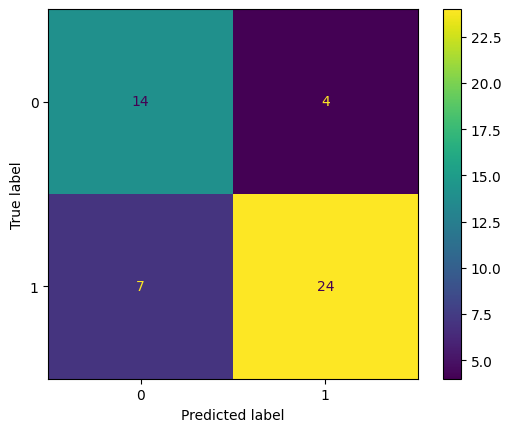

Params: output_size:64 | kernel_size:3 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.61
f1 score = 0.63


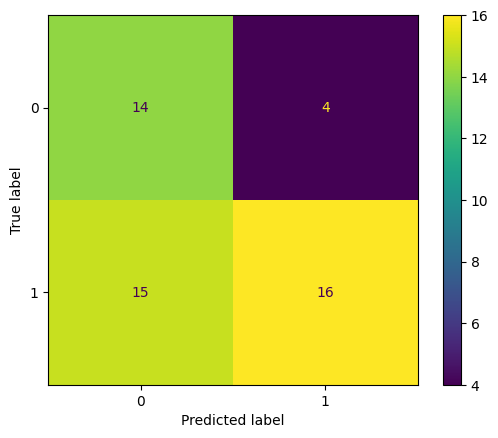

Params: output_size:64 | kernel_size:3 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.65
f1 score = 0.67


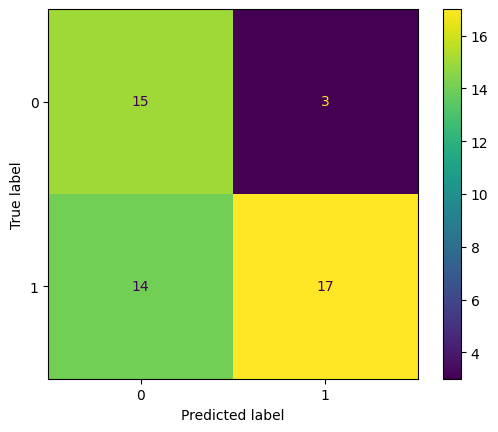

Params: output_size:64 | kernel_size:3 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.76
f1 score = 0.81


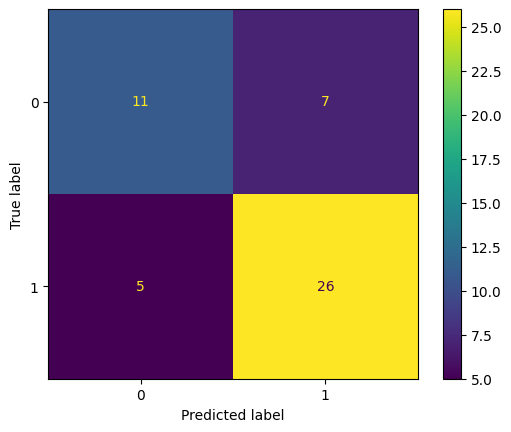

Params: output_size:64 | kernel_size:3 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


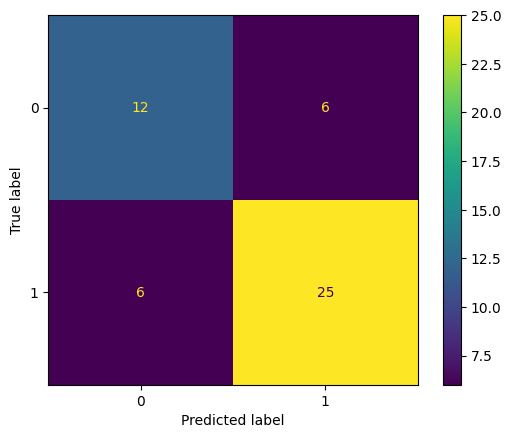

Params: output_size:64 | kernel_size:3 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.61
f1 score = 0.68


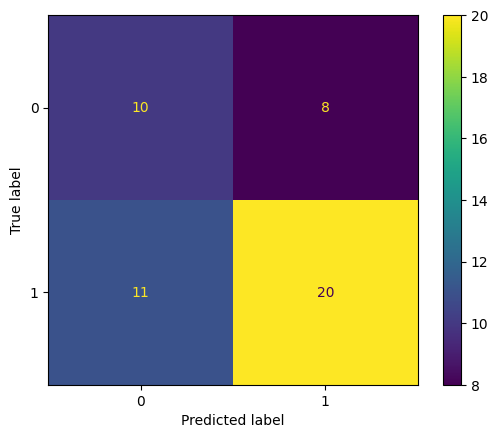

Params: output_size:64 | kernel_size:3 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.73
f1 score = 0.78


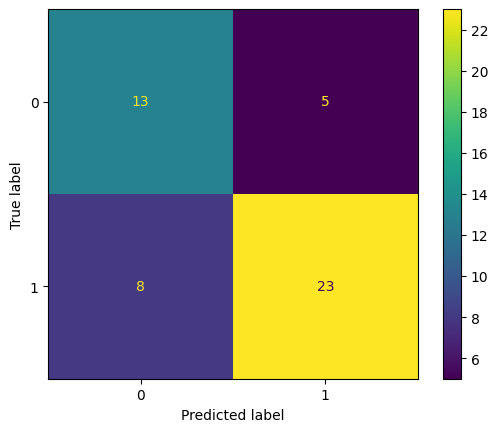

Params: output_size:64 | kernel_size:3 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.71
f1 score = 0.79


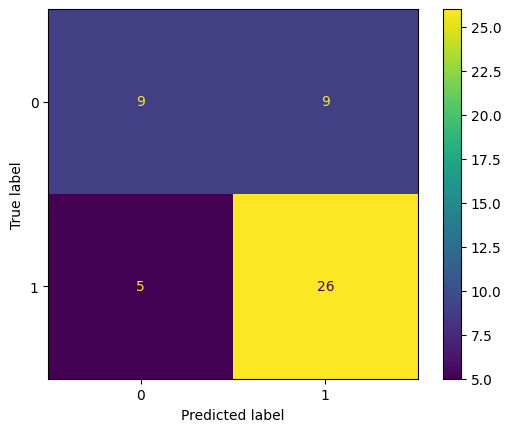

Params: output_size:64 | kernel_size:3 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.69
f1 score = 0.75


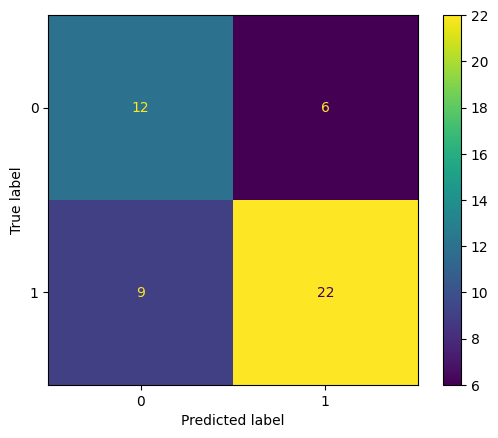

Params: output_size:64 | kernel_size:3 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.61
f1 score = 0.63


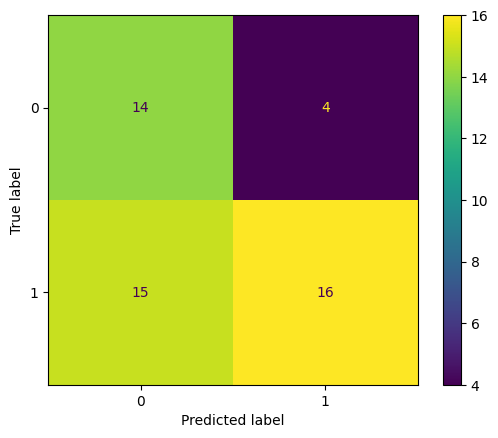

Params: output_size:64 | kernel_size:3 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.65
f1 score = 0.65


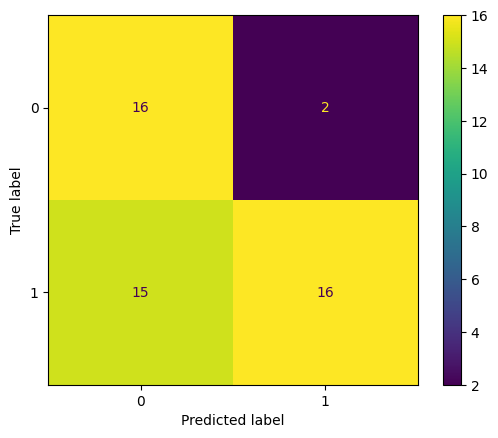

Params: output_size:64 | kernel_size:3 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.79


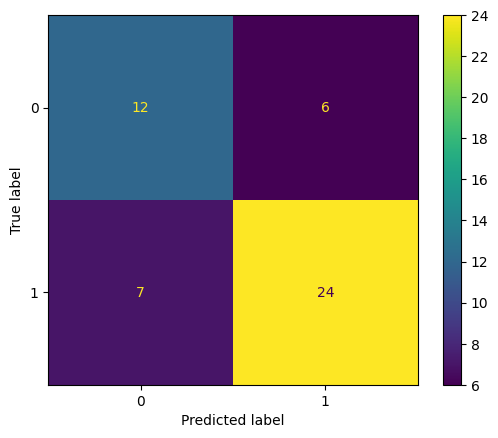

Params: output_size:64 | kernel_size:3 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.73
f1 score = 0.78


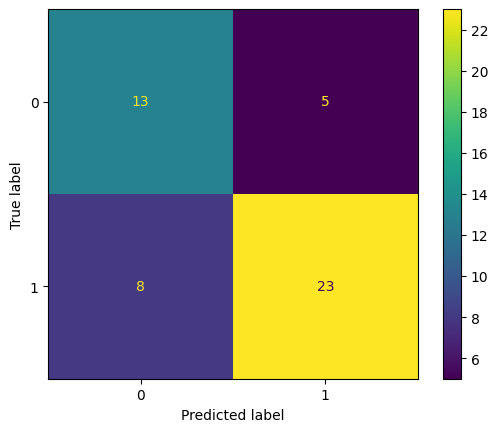

Params: output_size:64 | kernel_size:4 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.63
f1 score = 0.65


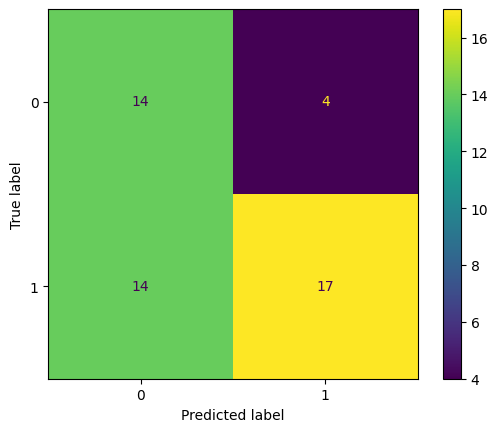

Params: output_size:64 | kernel_size:4 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.78
f1 score = 0.82


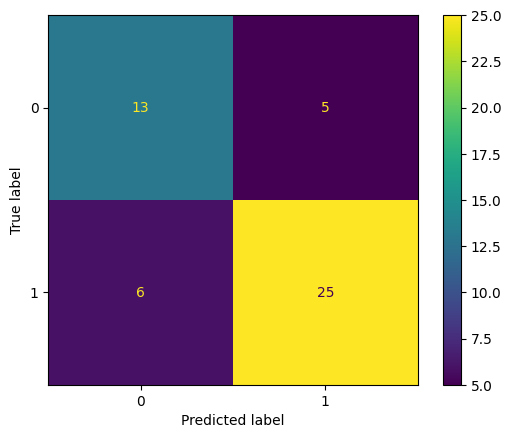

Params: output_size:64 | kernel_size:4 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.83


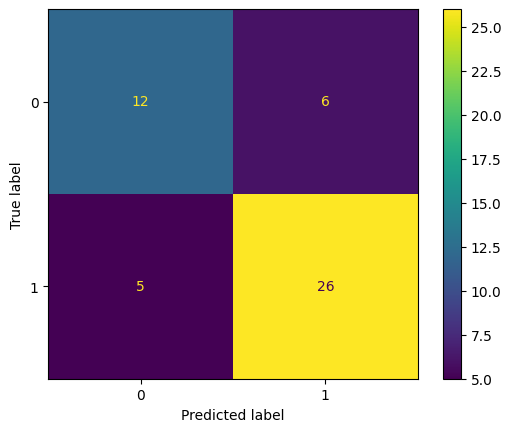

Params: output_size:64 | kernel_size:4 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


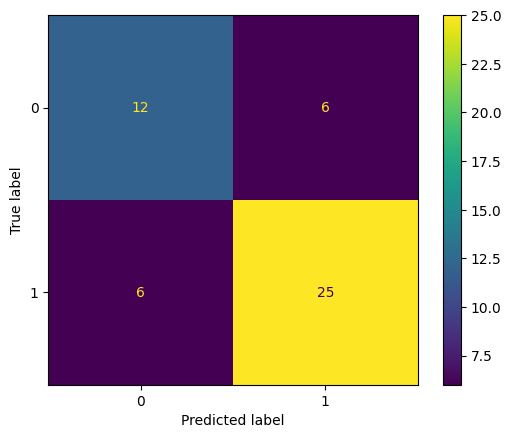

Params: output_size:64 | kernel_size:4 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.71
f1 score = 0.75


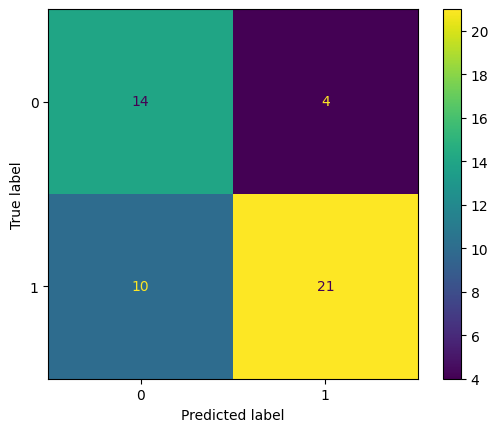

Params: output_size:64 | kernel_size:4 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.80


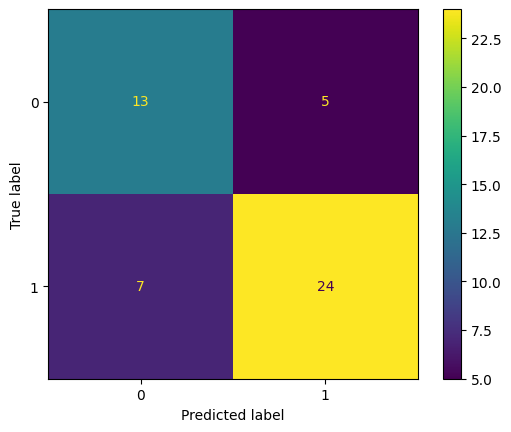

Params: output_size:64 | kernel_size:4 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.79


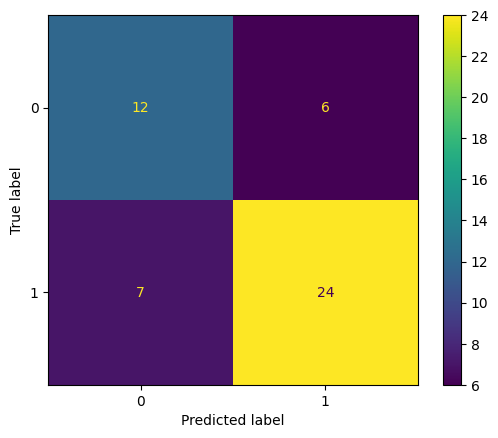

Params: output_size:64 | kernel_size:4 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.71
f1 score = 0.77


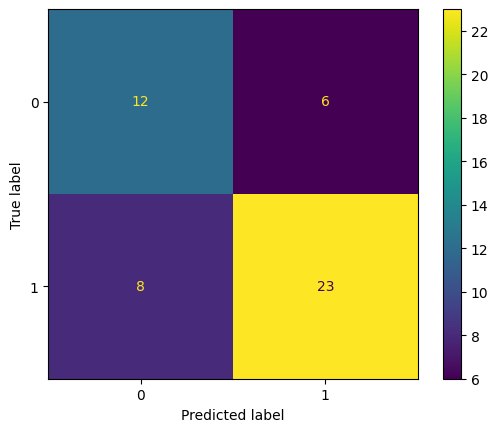

Params: output_size:64 | kernel_size:4 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.71
f1 score = 0.78


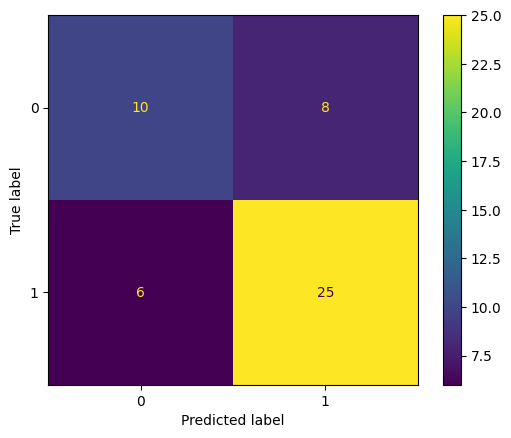

Params: output_size:64 | kernel_size:4 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.78


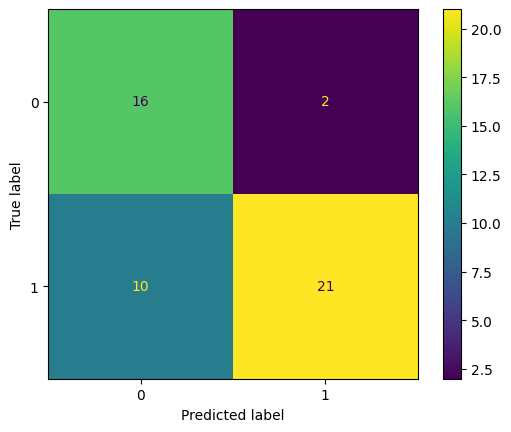

Params: output_size:64 | kernel_size:4 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.79


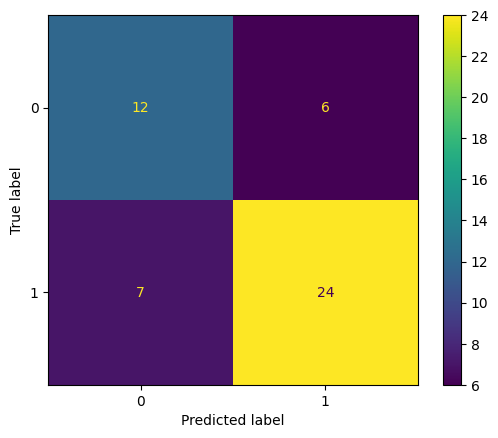

Params: output_size:64 | kernel_size:4 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.73
f1 score = 0.78


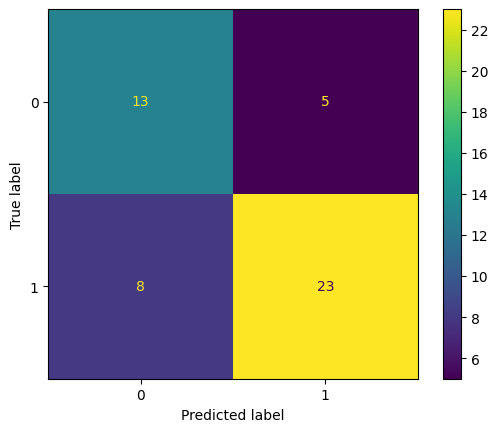

Params: output_size:64 | kernel_size:5 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.59
f1 score = 0.55


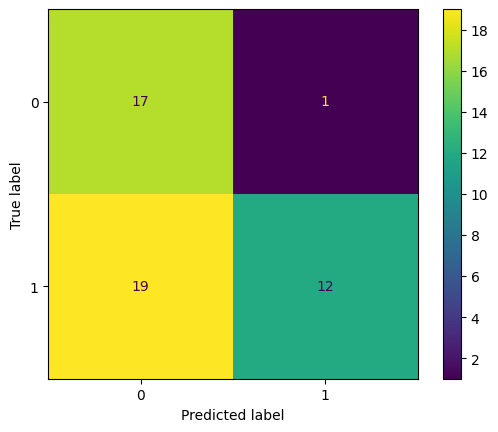

Params: output_size:64 | kernel_size:5 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.71
f1 score = 0.75


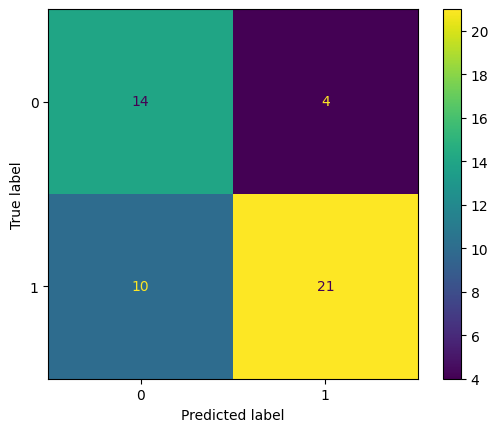

Params: output_size:64 | kernel_size:5 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.82
f1 score = 0.86


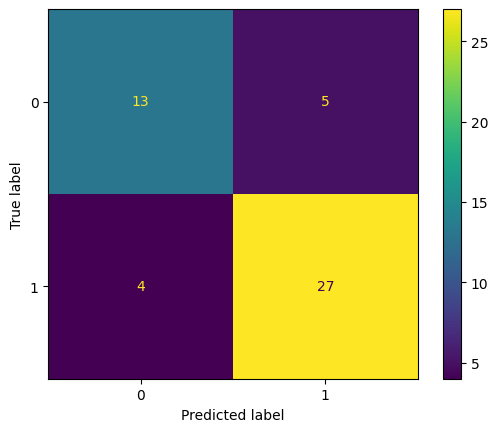

Params: output_size:64 | kernel_size:5 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.82


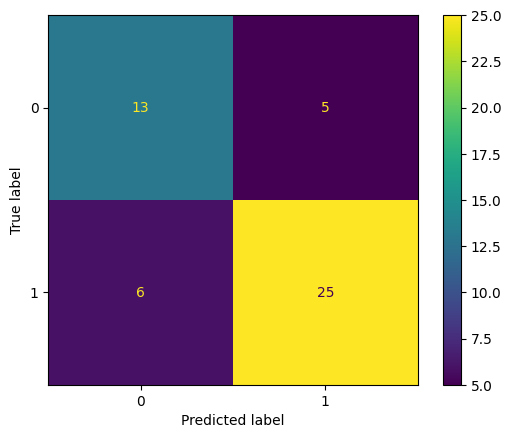

Params: output_size:64 | kernel_size:5 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.67
f1 score = 0.71


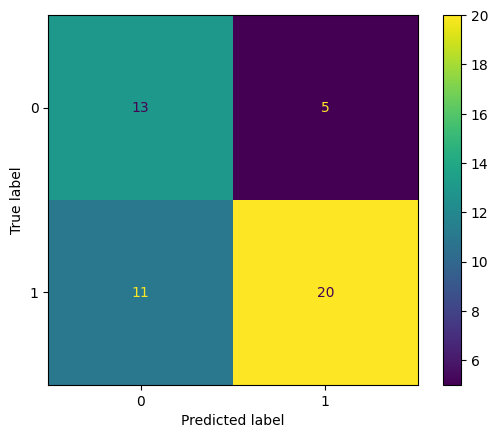

Params: output_size:64 | kernel_size:5 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.78


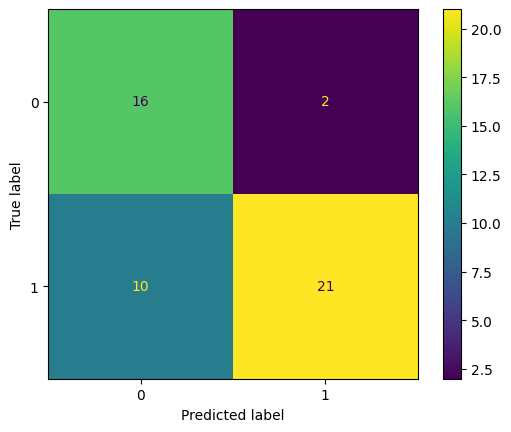

Params: output_size:64 | kernel_size:5 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.81


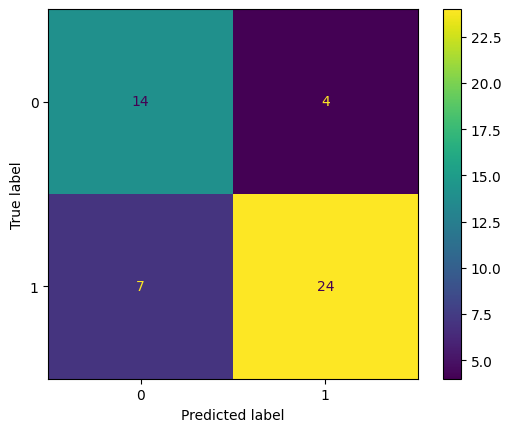

Params: output_size:64 | kernel_size:5 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


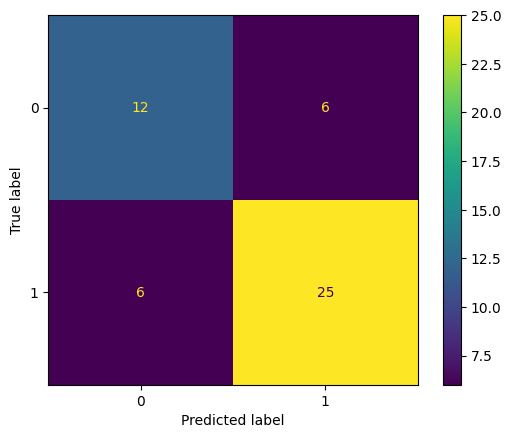

Params: output_size:64 | kernel_size:5 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.61
f1 score = 0.74


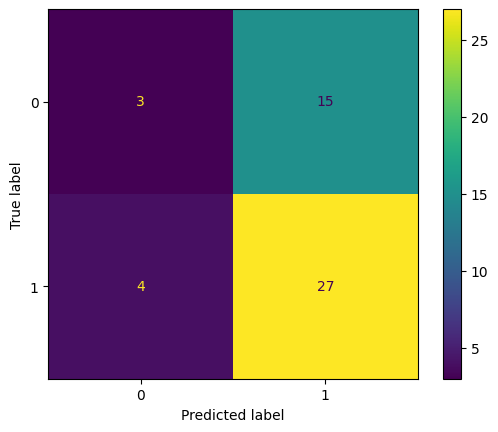

Params: output_size:64 | kernel_size:5 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.71
f1 score = 0.73


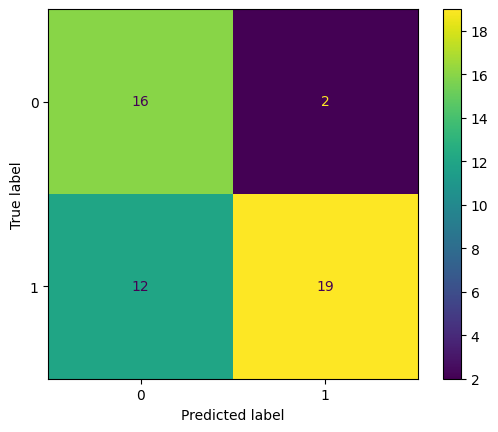

Params: output_size:64 | kernel_size:5 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.76


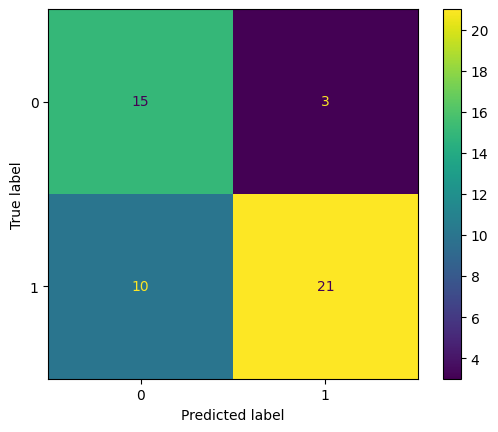

Params: output_size:64 | kernel_size:5 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.83


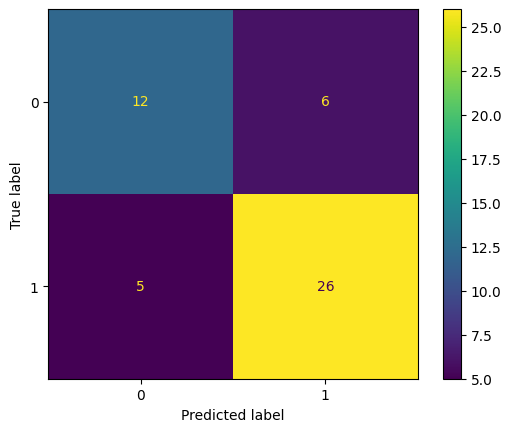

Params: output_size:128 | kernel_size:3 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.65
f1 score = 0.71


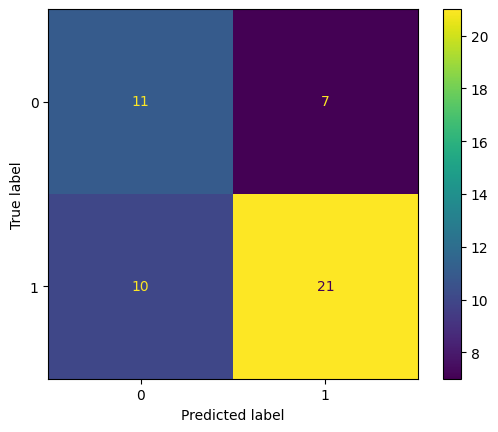

Params: output_size:128 | kernel_size:3 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.80


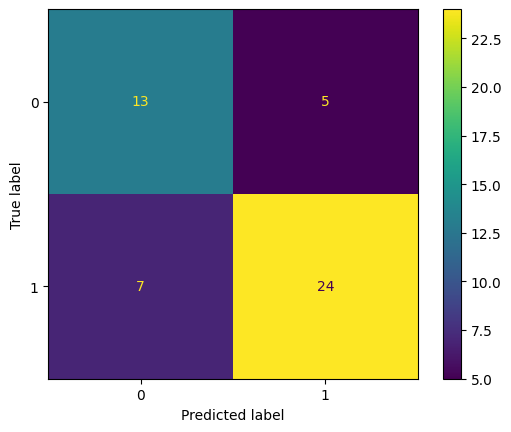

Params: output_size:128 | kernel_size:3 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.78


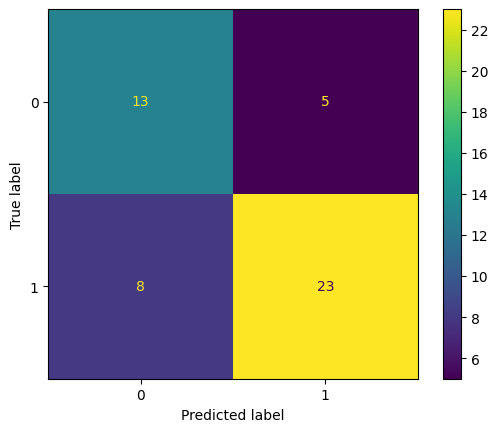

Params: output_size:128 | kernel_size:3 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.83


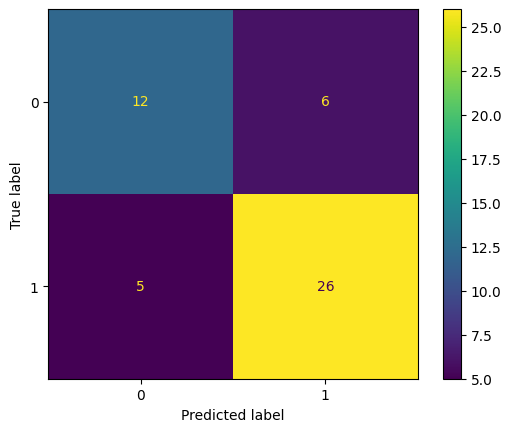

Params: output_size:128 | kernel_size:3 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.63
f1 score = 0.68


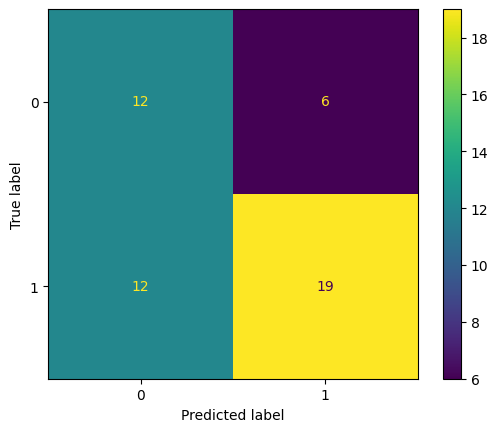

Params: output_size:128 | kernel_size:3 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.79


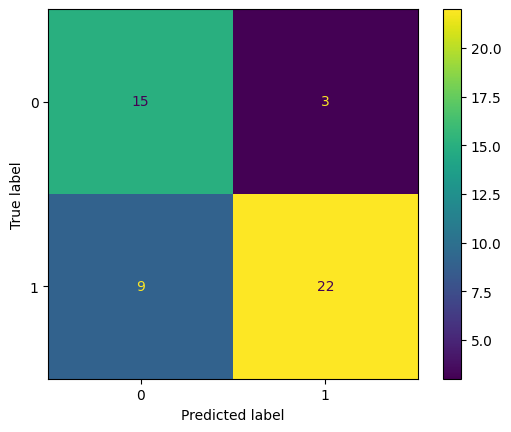

Params: output_size:128 | kernel_size:3 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.78


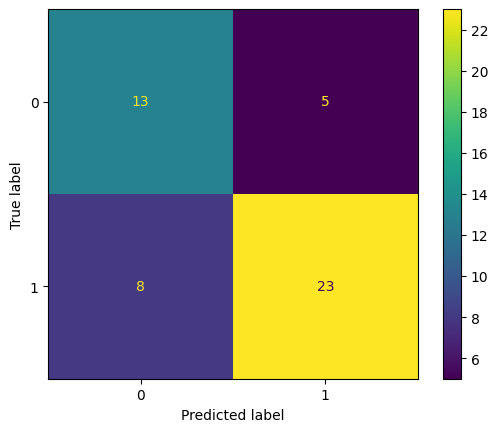

Params: output_size:128 | kernel_size:3 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.73
f1 score = 0.79


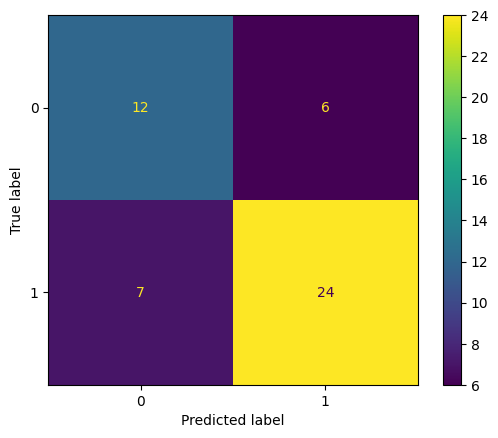

Params: output_size:128 | kernel_size:3 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.65
f1 score = 0.70


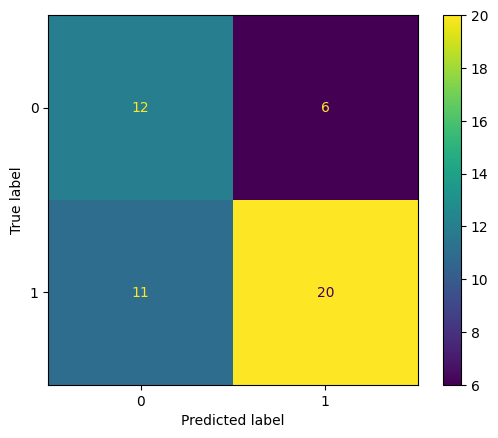

Params: output_size:128 | kernel_size:3 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.67
f1 score = 0.76


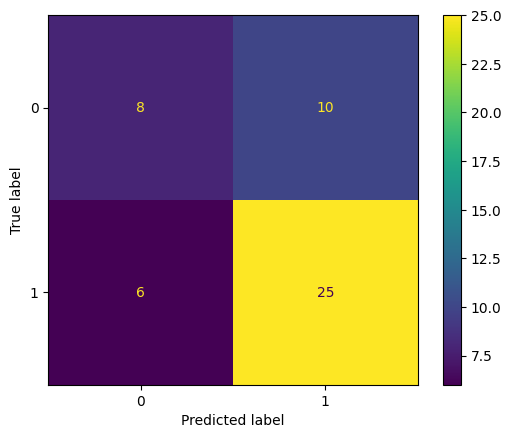

Params: output_size:128 | kernel_size:3 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.77


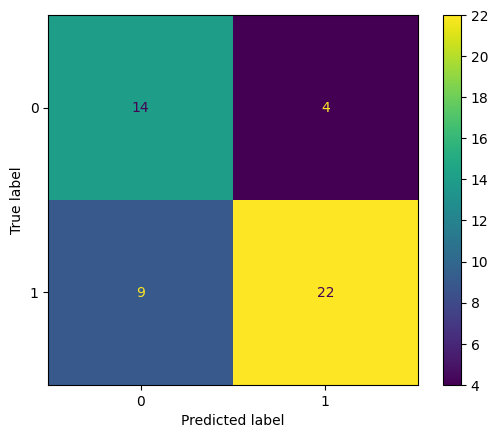

Params: output_size:128 | kernel_size:3 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.71
f1 score = 0.77


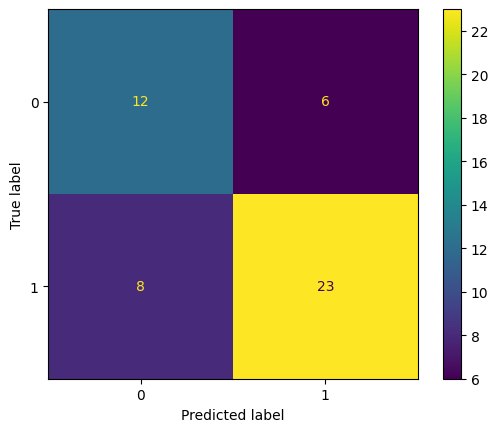

Params: output_size:128 | kernel_size:4 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.69
f1 score = 0.78


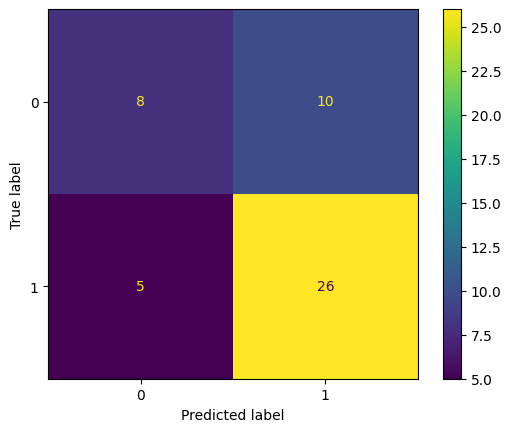

Params: output_size:128 | kernel_size:4 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.78
f1 score = 0.81


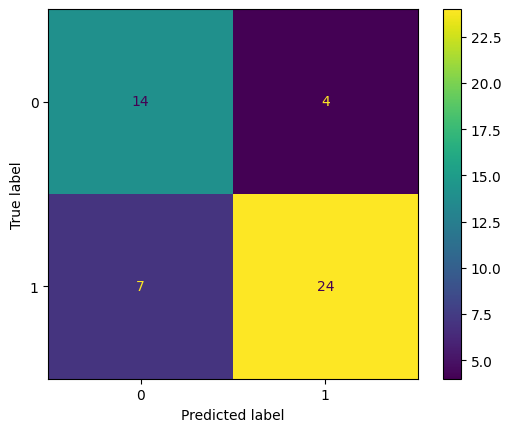

Params: output_size:128 | kernel_size:4 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.80
f1 score = 0.84


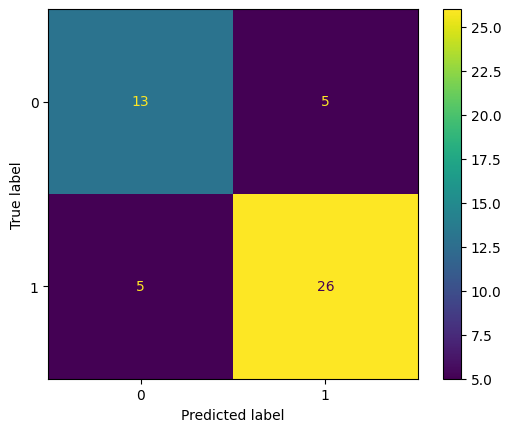

Params: output_size:128 | kernel_size:4 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


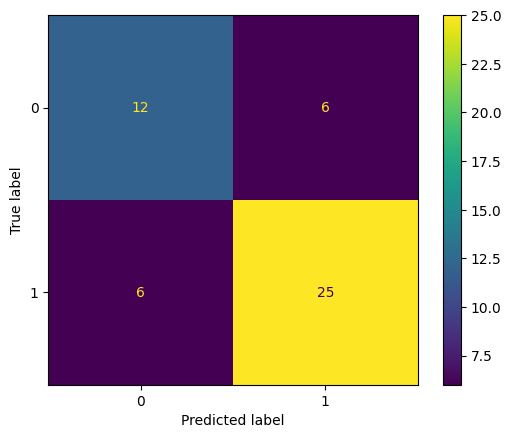

Params: output_size:128 | kernel_size:4 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.59
f1 score = 0.64


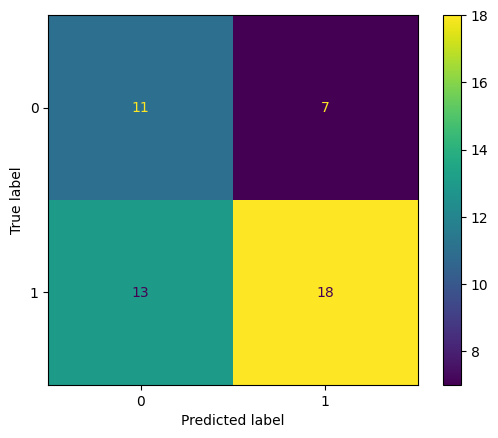

Params: output_size:128 | kernel_size:4 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.67
f1 score = 0.76


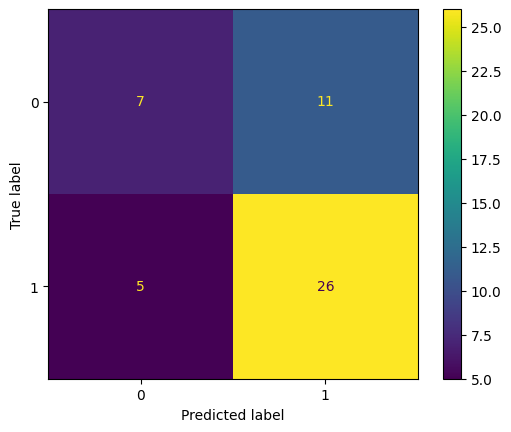

Params: output_size:128 | kernel_size:4 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.76
f1 score = 0.81


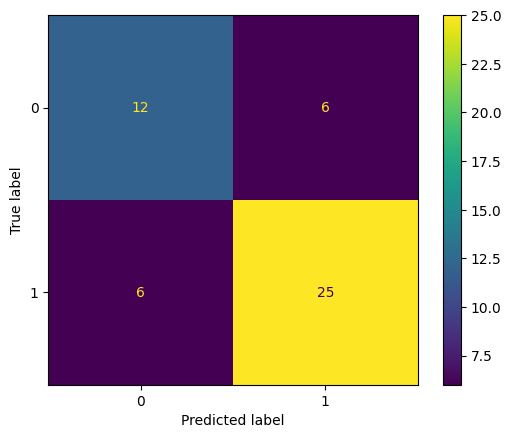

Params: output_size:128 | kernel_size:4 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


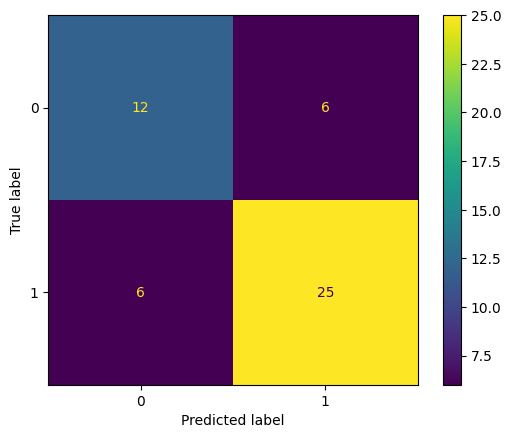

Params: output_size:128 | kernel_size:4 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.69
f1 score = 0.71


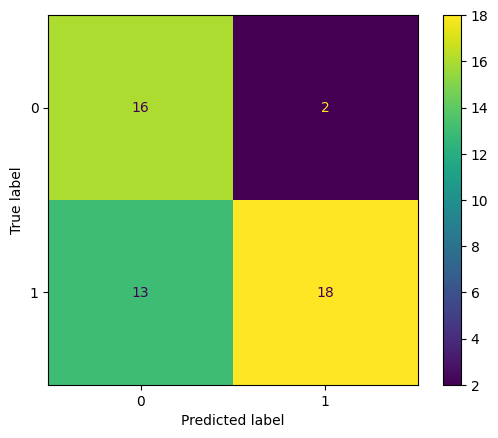

Params: output_size:128 | kernel_size:4 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.76
f1 score = 0.81


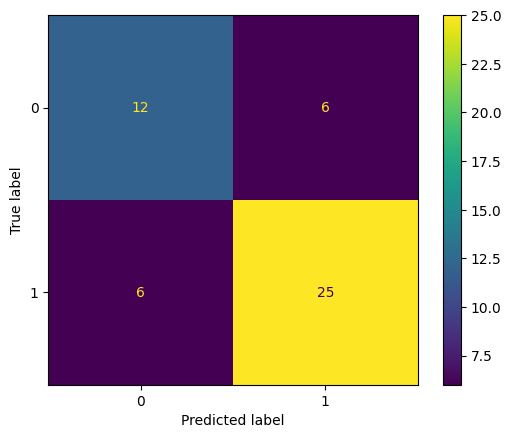

Params: output_size:128 | kernel_size:4 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.78


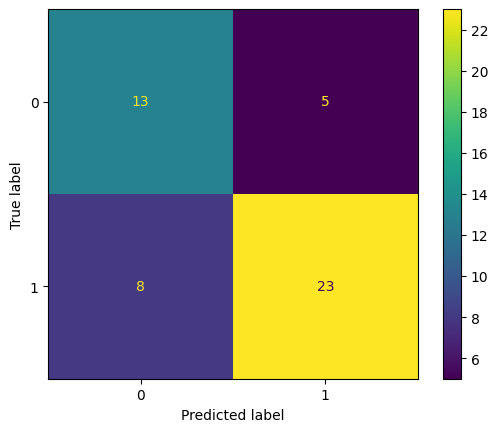

Params: output_size:128 | kernel_size:4 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.80


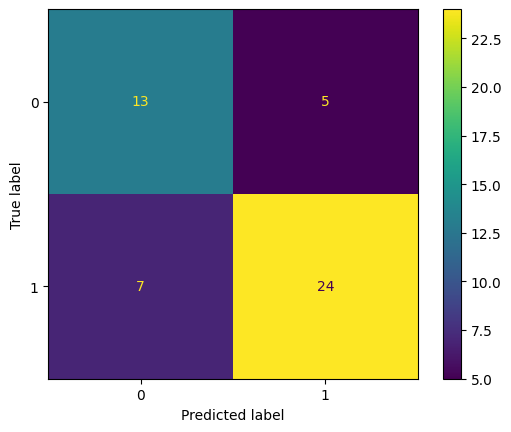

Params: output_size:128 | kernel_size:5 | pooling_size:2 | epochs:5
Fitting the model...
accuracy = 0.63
f1 score = 0.74


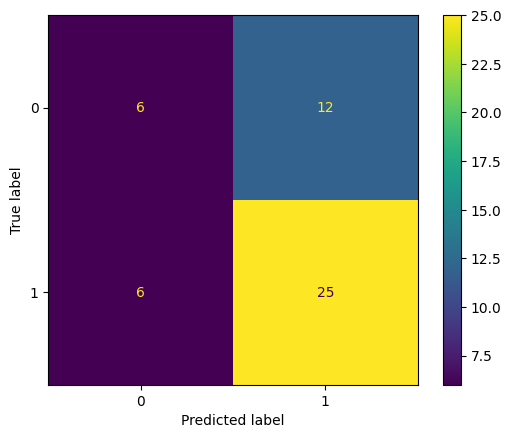

Params: output_size:128 | kernel_size:5 | pooling_size:2 | epochs:8
Fitting the model...
accuracy = 0.69
f1 score = 0.78


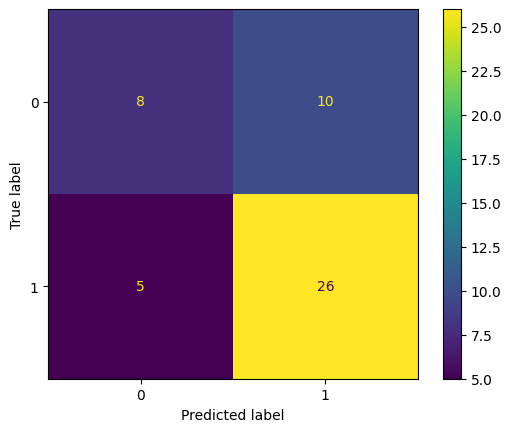

Params: output_size:128 | kernel_size:5 | pooling_size:2 | epochs:12
Fitting the model...
accuracy = 0.80
f1 score = 0.83


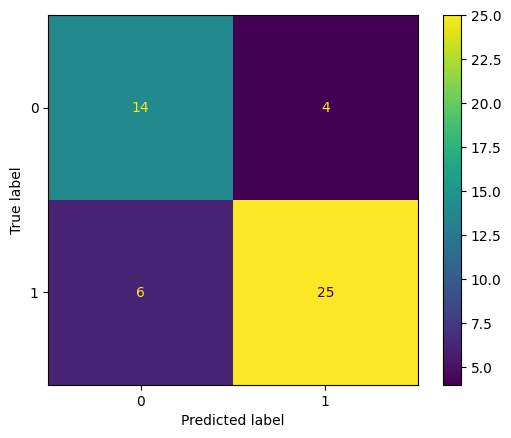

Params: output_size:128 | kernel_size:5 | pooling_size:2 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.82


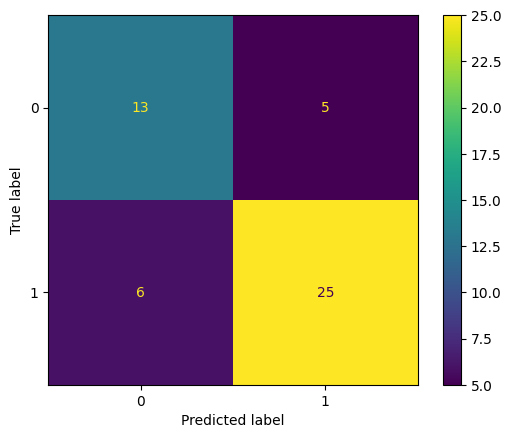

Params: output_size:128 | kernel_size:5 | pooling_size:3 | epochs:5
Fitting the model...
accuracy = 0.63
f1 score = 0.70


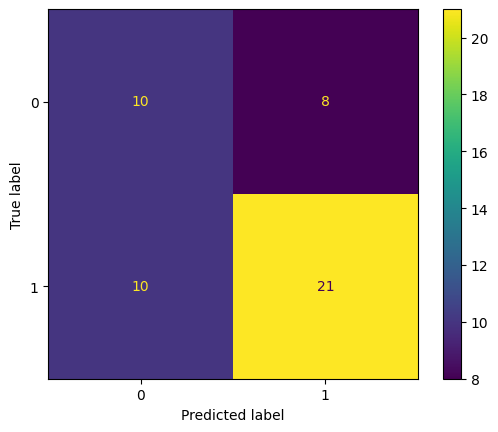

Params: output_size:128 | kernel_size:5 | pooling_size:3 | epochs:8
Fitting the model...
accuracy = 0.69
f1 score = 0.78


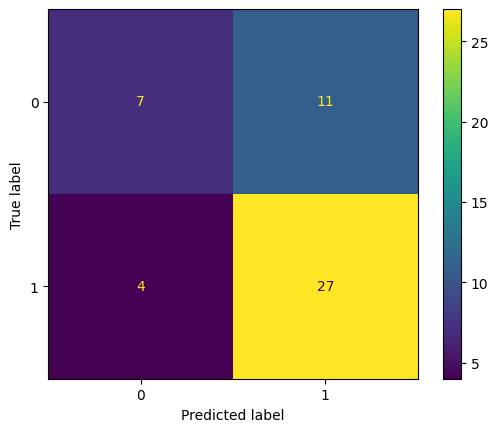

Params: output_size:128 | kernel_size:5 | pooling_size:3 | epochs:12
Fitting the model...
accuracy = 0.78
f1 score = 0.81


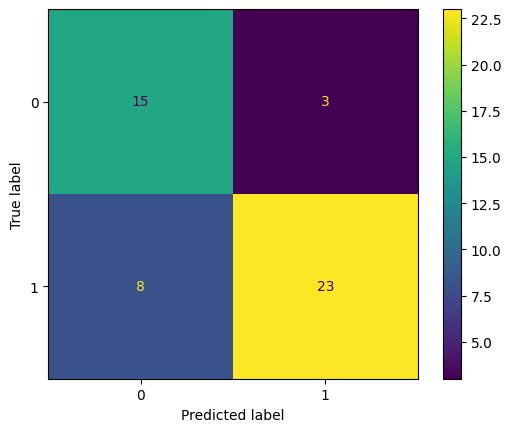

Params: output_size:128 | kernel_size:5 | pooling_size:3 | epochs:18
Fitting the model...
accuracy = 0.76
f1 score = 0.81


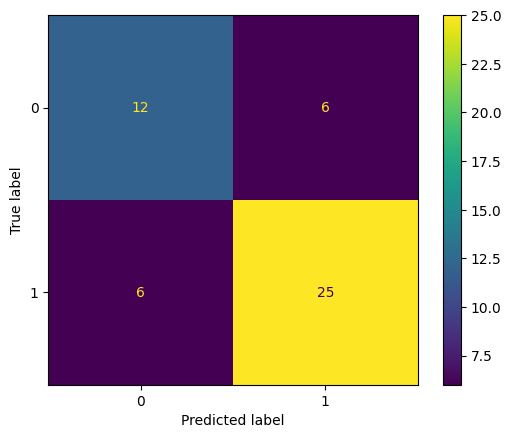

Params: output_size:128 | kernel_size:5 | pooling_size:4 | epochs:5
Fitting the model...
accuracy = 0.69
f1 score = 0.80


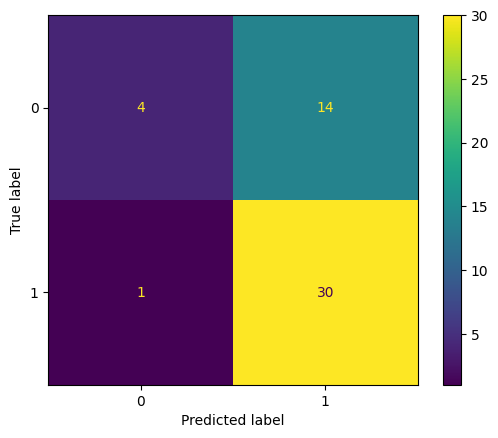

Params: output_size:128 | kernel_size:5 | pooling_size:4 | epochs:8
Fitting the model...
accuracy = 0.71
f1 score = 0.79


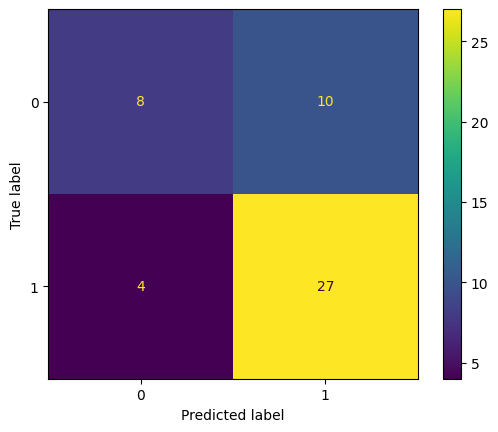

Params: output_size:128 | kernel_size:5 | pooling_size:4 | epochs:12
Fitting the model...
accuracy = 0.73
f1 score = 0.77


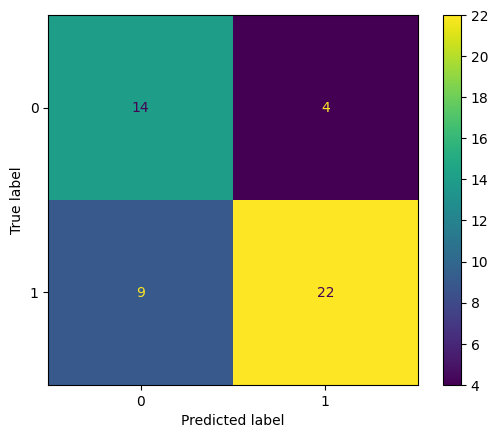

Params: output_size:128 | kernel_size:5 | pooling_size:4 | epochs:18
Fitting the model...
accuracy = 0.78
f1 score = 0.83


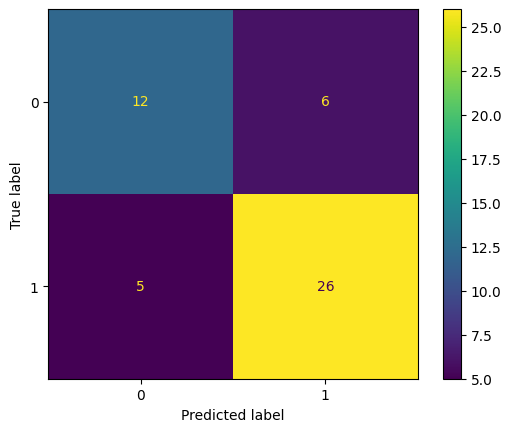

In [ ]:
output_sizes = [16, 32, 64, 128]
kernel_size = [3, 4, 5]
pooling_size = [2, 3, 4]
epochs = [5, 8, 12, 18]

for out in output_sizes:
  for kernel in kernel_size:
    for pool in pooling_size:
      for epoch in epochs:
        print(f'Params: output_size:{out} | kernel_size:{kernel} | pooling_size:{pool} | epochs:{epoch}')
        m = get_model_v1_custom(out_dimension=out, kernel_window_size=kernel, pooling_window_size=pool)
        acc, f1 = perform_training_on_model(m, X, y, epochs=epoch, verbose=False)
        best_acc = list(best.keys())[0]
        if best_acc < acc:
          best = {
                  acc: (m, f1, (out, kernel, pool, epoch))
                }

In [ ]:
# best model with best hyperparams is:
best

{0.8367346938775511: (<Sequential name=sequential_52, built=True>,
  0.8709677419354839,
  (32, 4, 2, 18))}